In [17]:
import tensorflow as tf 
print(tf.config.list_physical_devices('GPU'))

[]


In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Patch
plt.style.use('dark_background')

def convert_to_cxywh(data):
    # Extract bounding box coordinates from input data
    boxes = data[..., 0:4]
    
    # Extract labels from input data
    labels = data[..., 4:]
    
    # Create a mask with the same shape as the third dimension of data
    mask = np.zeros_like(data[..., 3:4])
    
    # Concatenate the mask with the labels along the third axis
    labels = np.concatenate((mask, labels), axis=2)
    
    # Find the index of the maximum value along the third axis
    labels = np.argmax(labels, axis=2)
    
    # Expand dimensions of labels to match the shape of boxes
    class_info = np.expand_dims(labels, axis=2)
    
    # Concatenate class information with boxes along the third axis
    cxywh = np.concatenate((class_info, boxes), axis=2)
    
    # Adjust the y-coordinate and height of the bounding boxes
    cxywh[..., 1] = cxywh[..., 1] - cxywh[..., 3] / 2
    cxywh[..., 2] = cxywh[..., 2] - cxywh[..., 4] / 2
    
    # Return the modified bounding box coordinates in the cxywh format
    return cxywh


def generate_colors(class_names=None, n_class=50):
    # Define a color map (cmap) containing color codes
    cmap = ["", "#dc143c", "#ffff00", "#00ff00", "#ff00ff", "#1e90ff", "#fff5ee",
            "#00ffff", "#8b008b", "#ff4500", "#8b4513", "#808000", "#483d8b",
            "#008000", "#000080", "#9acd32", "#ffa500", "#ba55d3", "#00fa9a",
            "#dc143c", "#0000ff", "#f08080", "#f0e68c", "#dda0dd", "#ff1493"]
    
    # Create an empty dictionary to store colors
    colors = dict()
    
    # Check if class_names argument is None
    if class_names == None:
        class_names = []
        # Generate class names as 'class1', 'class2', ...
        for i in range(n_class):
            class_names.append('class' + str(i + 1))
    
    # Assign colors from cmap to class names in colors dictionary
    for i in range(n_class):
        colors[class_names[i]] = cmap[i]
    
    return colors


# Define a list of class names
class_names = ['None', 'Text', 'Title', 'List', 'Table', 'Figure']

# Generate colors for the class names using the generate_colors function
colors = generate_colors(n_class=6, class_names=class_names)

def plot_layouts(pred, colors, class_names, path=""):
    # Set the dimensions of the figure
    figure_height = 15
    figure_width = 9
    
    # Create the figure with specified dimensions and black background
    fig = plt.figure(figsize=(figure_width, figure_height), dpi=50, facecolor=(0, 0, 0))
    
    # Define the height ratios for the grid layout
    height_ratio = [0.25, 1, 1, 1, 1, 1]
    
    # Create the grid layout for subplots
    grid = plt.GridSpec(6, 4,
                        hspace=0.05, wspace=0.05,
                        height_ratios=height_ratio,
                        left=0.02, right=0.98, top=0.98, bottom=0.02)
    
    # Initialize the index for the current subplot
    subplot_index = 0
    
    # Create an empty list for the legend patches
    legend = []
    
    # Add a subplot for the legend
    ax = fig.add_subplot(grid[subplot_index: subplot_index+4])
    subplot_index += 4
    
    # Create legend patches for class names and add them to the legend list
    for i in range(1, 6):
        legend.append(Patch(facecolor=colors[class_names[i]]+"40",
                            edgecolor=colors[class_names[i]],
                            label=class_names[i]))
    
    # Add the legend to the subplot
    ax.legend(handles=legend, ncol=3, loc=8, fontsize=25, facecolor=(0, 0, 0))
    ax.axis('off')
    
    # Iterate over 16 subplots
    for i in range(16):
        ax = fig.add_subplot(grid[subplot_index])
        subplot_index += 1
        
        # Get the data for the current subplot
        data = pred[i]
        
        # Add a black rectangle as the background for the subplot
        rect1 = patches.Rectangle((0, 0), 180, 240)
        rect1.set_color((0, 0, 0, 1))
        ax.add_patch(rect1)
        
        # Iterate over the bounding boxes in the data
        for box in data:
            c, x, y, w, h = box
            
            # Skip if the class is 0 (None)
            if c == 0:
                continue
            
            # Scale the coordinates and dimensions based on subplot size
            x = x * 180
            y = y * 240
            w = w * 180
            h = h * 240
            
            # Create a rectangle patch for the bounding box
            rect = patches.Rectangle((x, y), w, h, linewidth=2)
            rect.set_color(colors[class_names[int(c)]] + "00")
            rect.set_linestyle('-')
            rect.set_edgecolor(colors[class_names[int(c)]])
            ax.add_patch(rect)
        
        # Configure the subplot properties
        ax.plot()
        ax.set_facecolor((0, 0, 0))
        
        # Set the color and width of the subplot spines
        for spine in ax.spines.values():
            spine.set_edgecolor('green')
            spine.set_linewidth(2)
        
        # Invert the y-axis to match the image coordinate system
        ax.invert_yaxis()
        
        # Remove the x and y ticks
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Save the figure to thespecified path with a black background
    plt.savefig(path, facecolor=(0, 0, 0))

def layout_bbox(final_prediction, output_height, output_width):
    # Reshape final_pred to [64, 9, 9]
    final_prediction = tf.reshape(final_prediction, [64, 9, 9])
    
    # Slice the bounding box regression and class probability from final_pred
    bbox_reg = tf.slice(final_prediction, [0, 0, 0], [-1, -1, 4])
    cls_prob = tf.slice(final_prediction, [0, 0, 4], [-1, -1, 5])
    
    # Reshape bbox_reg to [64, 9, 4]
    bbox_reg = tf.reshape(bbox_reg, [64, 9, 4])
    
    # Compute the x, y coordinates, width, and height of the bounding box
    x_center = tf.slice(bbox_reg, [0, 0, 0], [-1, -1, 1]) * output_width
    y_center = tf.slice(bbox_reg, [0, 0, 1], [-1, -1, 1]) * output_height
    width = tf.slice(bbox_reg, [0, 0, 2], [-1, -1, 1]) * output_width
    height = tf.slice(bbox_reg, [0, 0, 3], [-1, -1, 1]) * output_height
    
    # Compute the coordinates of the corners of the bounding box
    x1 = x_center - 0.5 * width
    x2 = x_center + 0.5 * width
    y1 = y_center - 0.5 * height
    y2 = y_center + 0.5 * height
    
    # Generate the x and y coordinates for all pixels in the image
    x_t = tf.reshape(tf.range(output_width, dtype=tf.float32), [1, 1, 1, -1])
    x_t = tf.reshape(tf.tile(x_t, [64, 9, output_height, 1]), [64, 9, -1])
    y_t = tf.reshape(tf.range(output_height, dtype=tf.float32), [1, 1, -1, 1])
    y_t = tf.reshape(tf.tile(y_t, [64, 9, 1, output_width]), [64, 9, -1])
    
    # Compute the differences between the corner coordinates and the pixel coordinates
    x1_diff = tf.reshape(x_t - x1, [64, 9, output_height, output_width, 1])
    y1_diff = tf.reshape(y_t - y1, [64, 9, output_height, output_width, 1])
    x2_diff = tf.reshape(x2 - x_t, [64, 9, output_height, output_width, 1])
    y2_diff = tf.reshape(y2 - y_t, [64, 9, output_height, output_width, 1])
    
    # Compute the line functions for each side of the bounding box
    x1_line = tf.nn.relu(1.0 - tf.abs(x1_diff)) * tf.minimum(
        tf.nn.relu(y1_diff), 1.0) * tf.minimum(tf.nn.relu(y2_diff), 1.0)
    x2_line = tf.nn.relu(1.0 - tf.abs(x2_diff)) * tf.minimum(
        tf.nn.relu(y1_diff), 1.0) * tf.minimum(tf.nn.relu(y2_diff), 1.0)
    y1_line = tf.nn.relu(1.0 - tf.abs(y1_diff)) * tf.minimum(
        tf.nn.relu(x1_diff), 1.0) * tf.minimum(tf.nn.relu(x2_diff), 1.0)
    y2_line = tf.nn.relu(1.0 - tf.abs(y2_diff)) * tf.minimum(
        tf.nn.relu(x1_diff), 1.0) * tf.minimum(tf.nn.relu(x2_diff), 1.0)
    
    # Compute the maximum spatial probability among the line functions
    xy_max = tf.reduce_max(tf.concat(
        [x1_line, x2_line, y1_line, y2_line], axis=-1), axis=-1, keepdims=True)

    # Compute the spatial probability by multiplying xy_max with cls_prob
    spatial_prob = tf.multiply(
        tf.tile(xy_max, [1, 1, 1, 1, 5]), tf.reshape(cls_prob, [64, 9, 1, 1, 5]))

    # Compute the maximum spatial probability along the vertical dimension
    spatial_prob_max = tf.reduce_max(spatial_prob, axis=1, keepdims=False)

    return spatial_prob_max



In [3]:
import math
from glob import glob
import tensorflow as tf
from tensorflow.keras import initializers
import numpy as np
import random


class RelationModule(tf.keras.Model):
    def __init__(self, channels=128, output_dim=128, key_dim=128, **kwargs):
        super(RelationModule, self).__init__(**kwargs)
        
        # Set the dimensions for the key, output, and channels
        self.key_dim = channels
        self.output_dim = channels
        self.channels = channels
        
        # Define the key, query, value, and projection layers
        # The key layer maps the input to the output dimension
        self.key = tf.keras.layers.Conv2D(output_dim, (1, 1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        
        # The query layer maps the input to the key dimension
        self.query = tf.keras.layers.Conv2D(key_dim, (1, 1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        
        # The value layer maps the input to the output dimension
        self.value = tf.keras.layers.Conv2D(key_dim, (1, 1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        
        # The projection layer maps the output to the channel dimension
        self.projection = tf.keras.layers.Conv2D(channels, (1, 1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))

    def call(self, inputs):
        # Reshape the input tensors to have a shape of [batch_size, num_pixels, key_dim]
        key_embeddings = tf.reshape(self.key(inputs), [
                         inputs.shape[0], inputs.shape[1]*inputs.shape[2], self.key_dim])
        query_embeddings = tf.reshape(self.query(inputs), [
                         inputs.shape[0], inputs.shape[1]*inputs.shape[2], self.key_dim])
        
        # Transpose the query_embeddings tensor to have a shape of [batch_size, key_dim, num_pixels]
        query_embeddings = tf.transpose(query_embeddings, perm=[0, 2, 1])
        
        # Reshape the value tensor to have a shape of [batch_size, num_pixels, output_dim]
        value_embeddings = tf.reshape(self.value(inputs), [
                         inputs.shape[0], inputs.shape[1]*inputs.shape[2], self.output_dim])

        # Compute the attention weights by performing matrix multiplication between key_embeddings and query_embeddings
        # and then normalize them by dividing by the total number of pixels
        attention_weight = tf.matmul(
            key_embeddings, query_embeddings)/(inputs.shape[1]*inputs.shape[2])
        
        # Apply the attention weights to the values by performing matrix multiplication between
        # the transposed attention weights and value_embeddings
        out = tf.matmul(tf.transpose(attention_weight, perm=[0, 2, 1]), value_embeddings)
        
        # Reshape the output tensor to have the same shape as the input tensor
        out = tf.reshape(
            out, [inputs.shape[0], inputs.shape[1], inputs.shape[2], self.output_dim])
        
        # Apply the projection layer to map the output tensor to the channel dimension
        out = self.projection(out)
        return out


class Discriminator(tf.keras.Model):
    def __init__(self, n_filters=32, n_hidden=128, layout_dim=(28, 28), render=layout_bbox, **kwargs):
        super(Discriminator, self).__init__(**kwargs)
        self.layout_dim = layout_dim
        self.render = render
        
        # Activation function
        self.act = tf.keras.layers.LeakyReLU(alpha=0.2)
        
        # Convolutional layers
        self.conv1 = tf.keras.layers.Conv2D(32, (5, 5), input_shape=layout_dim, strides=(
            2, 2), padding='valid', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn1 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        
        self.conv2 = tf.keras.layers.Conv2D(32*2, (5, 5), strides=(2, 2), padding='valid', kernel_initializer=initializers.TruncatedNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn2 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        
        # Flatten layer
        self.flatten = tf.keras.layers.Flatten()
        
        # Fully connected layers
        self.fc1 = tf.keras.layers.Dense(512, kernel_initializer=initializers.RandomNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn3 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.fc2 = tf.keras.layers.Dense(1, kernel_initializer=initializers.RandomNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))

    def call(self, inputs):
        # Render the inputs using the given layout dimensions
        x = self.render(inputs, self.layout_dim[0], self.layout_dim[1])
        
        # Convolutional layer 1
        x = self.act(self.bn1(self.conv1(x)))
        
        # Convolutional layer 2
        x = self.act(self.bn2(self.conv2(x)))
        
        # Flatten the output tensor
        x = self.flatten(x)
        
        # Fully connected layer 1
        x = self.act(self.bn3(self.fc1(x)))
        
        # Fully connected layer 2 (output layer)
        out = self.fc2(x)
        
        return out


class Generator(tf.keras.Model):
    def __init__(self, n_filters=128, output_dim=2, n_component=128, n_class=1, include_probability=False, **kwargs):
        super(Generator, self).__init__(**kwargs)
        self.n_filters = n_filters
        self.output_dim = output_dim
        self.n_component = n_component
        self.n_class = n_class
        self.include_probability = include_probability
        
        # Activation function
        self.act = tf.keras.layers.ReLU()

        # Convolutional layers
        
        self.conv1_1 = tf.keras.layers.Conv2D(n_filters//4, (1, 1), input_shape=(self.n_component, 1, self.n_class+self.output_dim), strides=(
            1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn1_1 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.conv1_2 = tf.keras.layers.Conv2D(n_filters//16, (1, 1), strides=(1, 1), padding='same',
                                              kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn1_2 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.conv1_3 = tf.keras.layers.Conv2D(n_filters//16, (1, 1), strides=(1, 1), padding='same',
                                              kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn1_3 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.conv1_4 = tf.keras.layers.Conv2D(n_filters//4, (1, 1), strides=(1, 1), padding='same',
                                              kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn1_4 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)

        # Relation modules
        self.relation1 = RelationModule(
            channels=n_filters//4, output_dim=n_filters//4, key_dim=n_filters//4)
        self.relation2 = RelationModule(
            channels=n_filters//4, output_dim=n_filters//4, key_dim=n_filters//4)
        self.relation3 = RelationModule(
            channels=n_filters, output_dim=n_filters, key_dim=n_filters)
        self.relation4 = RelationModule(
            channels=n_filters, output_dim=n_filters, key_dim=n_filters)

        # Batch Normalization layers
        self.bn_x1 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.bn_x2 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.bn_x3 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.bn_x4 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)

        self.bn_x5 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.bn_x6 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.bn_x7 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.bn_x8 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        
        # More Convolutional layers
        self.conv2_1 = tf.keras.layers.Conv2D(n_filters, (1, 1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn2_1 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.conv2_2 = tf.keras.layers.Conv2D(n_filters//4, (1, 1), strides=(1, 1), padding='same',
                                              kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn2_2 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.conv2_3 = tf.keras.layers.Conv2D(n_filters//4, (1, 1), strides=(1, 1), padding='same',
                                              kernel_initializer=initializers.TruncatedNormal(stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn2_3 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        self.conv2_4 = tf.keras.layers.Conv2D(n_filters, (1, 1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.bn2_4 = tf.keras.layers.BatchNormalization(
            epsilon=1e-5, momentum=0.9)
        
        # Geometric parameter and class score layers
        self.geometric_param = tf.keras.layers.Conv2D(output_dim, (1, 1), strides=(
            1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(stddev=0.001, mean=0.0), bias_initializer=initializers.constant(0.0))
        self.class_score = tf.keras.layers.Conv2D(n_class, (1, 1), strides=(1, 1), padding='same', kernel_initializer=initializers.TruncatedNormal(
            stddev=0.02, mean=0.0), bias_initializer=initializers.constant(0.0))

    def call(self, x):

        # Reshape the input tensor
        x = tf.reshape(x, [x.shape[0], self.n_component,
                       1, self.n_class+self.output_dim])
        
        # Convolutional layers 1
        h1_0 = self.bn1_1(self.conv1_1(x))
        h1_1 = self.act(self.bn1_2(self.conv1_2(x)))
        h1_2 = self.act(self.bn1_3(self.conv1_3(h1_1)))
        h1_3 = self.bn1_4(self.conv1_4(h1_2))
        embedding = self.act(tf.add(h1_0, h1_3))
        embedding = tf.reshape(
            embedding, [x.shape[0], self.n_component, 1, 256])
        
        # Relation modules 1 and 2
        context = self.act(self.bn_x2(
            tf.add(embedding, self.bn_x1(self.relation1(embedding)))))
        context = self.act(self.bn_x4(
            tf.add(context, self.bn_x3(self.relation2(context)))))
        
        # Convolutional layers 2
        h2_0 = self.bn2_1(self.conv2_1(context))
        h2_1 = self.act(self.bn2_2(self.conv2_2(h2_0)))
        h2_2 = self.act(self.bn2_3(self.conv2_3(h2_1)))
        h2_3 = self.bn2_4(self.conv2_4(h2_2))
        decoded = self.act(tf.add(h2_0, h2_3))

        # Relation modules 3 and 4
        decoded = self.act(self.bn_x6(
            tf.add(decoded, self.bn_x5(self.relation3(decoded)))))
        decoded = self.act(self.bn_x8(
            tf.add(decoded, self.bn_x7(self.relation4(decoded)))))
        
        # Geometric parameters and class scores
        out = self.geometric_param(decoded)
        out = tf.sigmoid(tf.reshape(
            out, [-1, self.n_component, self.output_dim]))

        cls_score = self.class_score(decoded)
        cls_prob = tf.sigmoid(tf.reshape(
            cls_score, [-1, self.n_component, self.n_class]))
        final_pred = tf.concat([out, cls_prob], axis=-1)
        return final_pred


Epoch: [ 0] [  48/1093] time: 26.4952, lr:1.000E-05, d_loss: 1.3791, g_loss: 0.7167
Epoch: [ 0] [  98/1093] time: 41.6719, lr:1.000E-05, d_loss: 1.3590, g_loss: 0.7056
Epoch: [ 0] [ 148/1093] time: 56.6194, lr:1.000E-05, d_loss: 1.3564, g_loss: 0.6986
Epoch: [ 0] [ 198/1093] time: 71.3189, lr:1.000E-05, d_loss: 1.3642, g_loss: 0.6837
Epoch: [ 0] [ 248/1093] time: 86.1342, lr:1.000E-05, d_loss: 1.3582, g_loss: 0.6915
Epoch: [ 0] [ 298/1093] time: 100.6849, lr:1.000E-05, d_loss: 1.3548, g_loss: 0.7020
Epoch: [ 0] [ 348/1093] time: 117.4284, lr:1.000E-05, d_loss: 1.3504, g_loss: 0.7059
Epoch: [ 0] [ 398/1093] time: 132.4324, lr:1.000E-05, d_loss: 1.3584, g_loss: 0.7073
Epoch: [ 0] [ 448/1093] time: 148.0656, lr:1.000E-05, d_loss: 1.3538, g_loss: 0.7134
Epoch: [ 0] [ 498/1093] time: 163.0613, lr:1.000E-05, d_loss: 1.3530, g_loss: 0.7138
[Sample] d_loss: 1.37020421, g_loss: 0.72407138
Epoch: [ 0] [ 548/1093] time: 179.0060, lr:1.000E-05, d_loss: 1.3377, g_loss: 0.7230
Epoch: [ 0] [ 598/1093

Epoch: [ 4] [ 276/1093] time: 1412.8596, lr:1.000E-05, d_loss: 0.6443, g_loss: 1.0154
Epoch: [ 4] [ 326/1093] time: 1427.2359, lr:1.000E-05, d_loss: 0.6878, g_loss: 1.0353
Epoch: [ 4] [ 376/1093] time: 1441.5594, lr:1.000E-05, d_loss: 0.7357, g_loss: 0.9403
Epoch: [ 4] [ 426/1093] time: 1455.9240, lr:1.000E-05, d_loss: 0.6939, g_loss: 1.0159
Epoch: [ 4] [ 476/1093] time: 1470.3851, lr:1.000E-05, d_loss: 0.8261, g_loss: 0.9158
Epoch: [ 4] [ 526/1093] time: 1484.7353, lr:1.000E-05, d_loss: 0.7798, g_loss: 1.0621
Epoch: [ 4] [ 576/1093] time: 1499.1152, lr:1.000E-05, d_loss: 0.7501, g_loss: 1.1037
Epoch: [ 4] [ 626/1093] time: 1513.3711, lr:1.000E-05, d_loss: 0.6951, g_loss: 1.1441
[Sample] d_loss: 0.81530523, g_loss: 1.08151448
Epoch: [ 4] [ 676/1093] time: 1528.4035, lr:1.000E-05, d_loss: 0.7213, g_loss: 1.0016
Epoch: [ 4] [ 726/1093] time: 1542.7131, lr:1.000E-05, d_loss: 0.6635, g_loss: 1.0718
Epoch: [ 4] [ 776/1093] time: 1557.0825, lr:1.000E-05, d_loss: 0.7449, g_loss: 1.0977
Epoch:

Epoch: [ 8] [ 454/1093] time: 2748.2876, lr:1.000E-05, d_loss: 0.6055, g_loss: 1.2576
Epoch: [ 8] [ 504/1093] time: 2763.1815, lr:1.000E-05, d_loss: 0.4334, g_loss: 1.5337
Epoch: [ 8] [ 554/1093] time: 2777.5366, lr:1.000E-05, d_loss: 0.6510, g_loss: 1.4872
Epoch: [ 8] [ 604/1093] time: 2794.1498, lr:1.000E-05, d_loss: 0.6730, g_loss: 1.4798
Epoch: [ 8] [ 654/1093] time: 2809.4401, lr:1.000E-05, d_loss: 0.4733, g_loss: 1.4989
Epoch: [ 8] [ 704/1093] time: 2826.0104, lr:1.000E-05, d_loss: 0.6174, g_loss: 1.3371
Epoch: [ 8] [ 754/1093] time: 2844.3214, lr:1.000E-05, d_loss: 0.5466, g_loss: 1.5521
[Sample] d_loss: 0.71162730, g_loss: 1.56153202
Epoch: [ 8] [ 804/1093] time: 2861.2231, lr:1.000E-05, d_loss: 0.4744, g_loss: 1.5552
Epoch: [ 8] [ 854/1093] time: 2875.6450, lr:1.000E-05, d_loss: 0.6902, g_loss: 1.3848
Epoch: [ 8] [ 904/1093] time: 2890.2746, lr:1.000E-05, d_loss: 0.7558, g_loss: 1.4803
Epoch: [ 8] [ 954/1093] time: 2904.6194, lr:1.000E-05, d_loss: 0.6508, g_loss: 1.5113
Epoch:

c:\conda_temp/ipykernel_18320/637494572.py:44: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(width, height), dpi=50, facecolor=(0, 0, 0))


[Sample] d_loss: 0.75128418, g_loss: 1.64326966
Epoch: [ 9] [ 711/1093] time: 3176.6546, lr:1.000E-05, d_loss: 0.7882, g_loss: 1.6864
Epoch: [ 9] [ 761/1093] time: 3193.9141, lr:1.000E-05, d_loss: 0.5052, g_loss: 1.4520
Epoch: [ 9] [ 811/1093] time: 3208.4240, lr:1.000E-05, d_loss: 0.7582, g_loss: 1.1884
Epoch: [ 9] [ 861/1093] time: 3222.7816, lr:1.000E-05, d_loss: 0.7004, g_loss: 1.3272
Epoch: [ 9] [ 911/1093] time: 3237.0470, lr:1.000E-05, d_loss: 0.5383, g_loss: 1.3208
Epoch: [ 9] [ 961/1093] time: 3251.5817, lr:1.000E-05, d_loss: 0.5574, g_loss: 1.4186
Epoch: [ 9] [1011/1093] time: 3269.0526, lr:1.000E-05, d_loss: 0.6316, g_loss: 1.4382
Epoch: [ 9] [1061/1093] time: 3285.8266, lr:1.000E-05, d_loss: 0.6772, g_loss: 1.2119
Epoch: [10] [  18/1093] time: 3302.6104, lr:1.000E-05, d_loss: 0.6390, g_loss: 1.7719
Epoch: [10] [  68/1093] time: 3323.3771, lr:1.000E-05, d_loss: 0.6375, g_loss: 1.8600
[Sample] d_loss: 0.65538704, g_loss: 1.75268292
Epoch: [10] [ 118/1093] time: 3343.0087, lr:

Epoch: [13] [ 839/1093] time: 4651.4427, lr:1.000E-05, d_loss: 0.2454, g_loss: 2.0003
Epoch: [13] [ 889/1093] time: 4668.0772, lr:1.000E-05, d_loss: 0.2956, g_loss: 2.0498
Epoch: [13] [ 939/1093] time: 4685.1035, lr:1.000E-05, d_loss: 0.4006, g_loss: 1.9786
Epoch: [13] [ 989/1093] time: 4701.4823, lr:1.000E-05, d_loss: 0.2791, g_loss: 2.1007
Epoch: [13] [1039/1093] time: 4716.1850, lr:1.000E-05, d_loss: 0.4557, g_loss: 2.0224
Epoch: [13] [1089/1093] time: 4730.8804, lr:1.000E-05, d_loss: 0.3667, g_loss: 2.0204
Epoch: [14] [  46/1093] time: 4745.9900, lr:1.000E-05, d_loss: 0.2926, g_loss: 2.1428
Epoch: [14] [  96/1093] time: 4762.7763, lr:1.000E-05, d_loss: 0.4961, g_loss: 2.1193
Epoch: [14] [ 146/1093] time: 4782.0728, lr:1.000E-05, d_loss: 0.2722, g_loss: 2.0056
Epoch: [14] [ 196/1093] time: 4801.2054, lr:1.000E-05, d_loss: 0.2865, g_loss: 1.9392
[Sample] d_loss: 0.53772002, g_loss: 1.69500172
Epoch: [14] [ 246/1093] time: 4822.2192, lr:1.000E-05, d_loss: 0.3079, g_loss: 2.4441
Epoch:

Epoch: [17] [1017/1093] time: 6170.7091, lr:1.000E-05, d_loss: 0.1966, g_loss: 2.9316
Epoch: [17] [1067/1093] time: 6188.7597, lr:1.000E-05, d_loss: 0.2080, g_loss: 2.7093
Epoch: [18] [  24/1093] time: 6206.3439, lr:1.000E-05, d_loss: 0.2760, g_loss: 2.5141
Epoch: [18] [  74/1093] time: 6220.9018, lr:1.000E-05, d_loss: 0.1735, g_loss: 2.7415
Epoch: [18] [ 124/1093] time: 6235.4819, lr:1.000E-05, d_loss: 0.1788, g_loss: 2.8580
Epoch: [18] [ 174/1093] time: 6249.8852, lr:1.000E-05, d_loss: 0.2782, g_loss: 2.5823
Epoch: [18] [ 224/1093] time: 6264.4269, lr:1.000E-05, d_loss: 0.1613, g_loss: 2.8255
Epoch: [18] [ 274/1093] time: 6279.4720, lr:1.000E-05, d_loss: 0.2181, g_loss: 2.3972
Epoch: [18] [ 324/1093] time: 6293.9888, lr:1.000E-05, d_loss: 0.2067, g_loss: 2.5337
[Sample] d_loss: 0.38486865, g_loss: 2.85031748
Epoch: [18] [ 374/1093] time: 6309.0252, lr:1.000E-05, d_loss: 0.1390, g_loss: 2.9677
Epoch: [18] [ 424/1093] time: 6323.4584, lr:1.000E-05, d_loss: 0.1563, g_loss: 2.7429
Epoch:

Epoch: [22] [ 102/1093] time: 7637.8708, lr:1.000E-06, d_loss: 0.2899, g_loss: 2.6007
Epoch: [22] [ 152/1093] time: 7655.0684, lr:1.000E-06, d_loss: 0.3353, g_loss: 2.7692
Epoch: [22] [ 202/1093] time: 7672.2847, lr:1.000E-06, d_loss: 0.1316, g_loss: 2.8970
Epoch: [22] [ 252/1093] time: 7688.3616, lr:1.000E-06, d_loss: 0.1015, g_loss: 3.0825
Epoch: [22] [ 302/1093] time: 7704.1970, lr:1.000E-06, d_loss: 0.1043, g_loss: 3.1502
Epoch: [22] [ 352/1093] time: 7722.0327, lr:1.000E-06, d_loss: 0.1170, g_loss: 2.8012
Epoch: [22] [ 402/1093] time: 7737.7033, lr:1.000E-06, d_loss: 0.1199, g_loss: 3.1291
Epoch: [22] [ 452/1093] time: 7752.5675, lr:1.000E-06, d_loss: 0.1211, g_loss: 3.0738
[Sample] d_loss: 0.33964807, g_loss: 2.93968892
Epoch: [22] [ 502/1093] time: 7767.6567, lr:1.000E-06, d_loss: 0.1767, g_loss: 2.8433
Epoch: [22] [ 552/1093] time: 7782.3063, lr:1.000E-06, d_loss: 0.1966, g_loss: 2.7749
Epoch: [22] [ 602/1093] time: 7797.5470, lr:1.000E-06, d_loss: 0.1422, g_loss: 3.0968
Epoch:

Epoch: [26] [ 280/1093] time: 9193.8764, lr:1.000E-06, d_loss: 0.0715, g_loss: 3.2905
Epoch: [26] [ 330/1093] time: 9219.7510, lr:1.000E-06, d_loss: 0.1073, g_loss: 3.2479
Epoch: [26] [ 380/1093] time: 9242.4614, lr:1.000E-06, d_loss: 0.1473, g_loss: 3.1240
Epoch: [26] [ 430/1093] time: 9265.2994, lr:1.000E-06, d_loss: 0.1120, g_loss: 3.2623
Epoch: [26] [ 480/1093] time: 9288.9009, lr:1.000E-06, d_loss: 0.1672, g_loss: 3.0901
Epoch: [26] [ 530/1093] time: 9312.5001, lr:1.000E-06, d_loss: 0.1035, g_loss: 3.3160
Epoch: [26] [ 580/1093] time: 9337.7270, lr:1.000E-06, d_loss: 0.1686, g_loss: 3.2932
[Sample] d_loss: 0.30891925, g_loss: 3.18194103
Epoch: [26] [ 630/1093] time: 9363.3440, lr:1.000E-06, d_loss: 0.0728, g_loss: 3.3888
Epoch: [26] [ 680/1093] time: 9387.1264, lr:1.000E-06, d_loss: 0.0957, g_loss: 3.3806
Epoch: [26] [ 730/1093] time: 9410.5015, lr:1.000E-06, d_loss: 0.0920, g_loss: 3.1279
Epoch: [26] [ 780/1093] time: 9431.0811, lr:1.000E-06, d_loss: 0.1170, g_loss: 3.5160
Epoch:

Epoch: [30] [ 408/1093] time: 10782.3619, lr:1.000E-06, d_loss: 0.0766, g_loss: 3.3706
Epoch: [30] [ 458/1093] time: 10800.0757, lr:1.000E-06, d_loss: 0.0987, g_loss: 3.2906
Epoch: [30] [ 508/1093] time: 10816.3812, lr:1.000E-06, d_loss: 0.0919, g_loss: 3.1897
Epoch: [30] [ 558/1093] time: 10833.4407, lr:1.000E-06, d_loss: 0.1192, g_loss: 3.1253
Epoch: [30] [ 608/1093] time: 10851.4324, lr:1.000E-06, d_loss: 0.0775, g_loss: 3.3647
Epoch: [30] [ 658/1093] time: 10869.0211, lr:1.000E-06, d_loss: 0.0696, g_loss: 3.3274
Epoch: [30] [ 708/1093] time: 10884.4188, lr:1.000E-06, d_loss: 0.1002, g_loss: 3.1591
[Sample] d_loss: 0.26426098, g_loss: 3.19067526
Epoch: [30] [ 758/1093] time: 10900.1709, lr:1.000E-06, d_loss: 0.0942, g_loss: 3.2259
Epoch: [30] [ 808/1093] time: 10914.8825, lr:1.000E-06, d_loss: 0.0954, g_loss: 3.3012
Epoch: [30] [ 858/1093] time: 10929.5728, lr:1.000E-06, d_loss: 0.1406, g_loss: 3.3169
Epoch: [30] [ 908/1093] time: 10944.3427, lr:1.000E-06, d_loss: 0.3541, g_loss: 3.

Epoch: [34] [ 536/1093] time: 12266.6388, lr:1.000E-06, d_loss: 0.0731, g_loss: 3.3990
Epoch: [34] [ 586/1093] time: 12282.8432, lr:1.000E-06, d_loss: 0.1392, g_loss: 3.6828
Epoch: [34] [ 636/1093] time: 12299.1259, lr:1.000E-06, d_loss: 0.0874, g_loss: 3.5051
Epoch: [34] [ 686/1093] time: 12315.1656, lr:1.000E-06, d_loss: 0.1198, g_loss: 3.4115
Epoch: [34] [ 736/1093] time: 12331.9329, lr:1.000E-06, d_loss: 0.0615, g_loss: 3.5936
Epoch: [34] [ 786/1093] time: 12348.7726, lr:1.000E-06, d_loss: 0.0731, g_loss: 3.4633
Epoch: [34] [ 836/1093] time: 12364.8200, lr:1.000E-06, d_loss: 0.0759, g_loss: 3.5076
[Sample] d_loss: 0.22213599, g_loss: 3.44580030
Epoch: [34] [ 886/1093] time: 12382.2150, lr:1.000E-06, d_loss: 0.0921, g_loss: 3.4388
Epoch: [34] [ 936/1093] time: 12398.2923, lr:1.000E-06, d_loss: 0.1033, g_loss: 3.5292
Epoch: [34] [ 986/1093] time: 12413.8355, lr:1.000E-06, d_loss: 0.1143, g_loss: 3.3790
Epoch: [34] [1036/1093] time: 12430.0820, lr:1.000E-06, d_loss: 0.0801, g_loss: 3.

Epoch: [38] [ 664/1093] time: 13714.6877, lr:1.000E-06, d_loss: 0.0707, g_loss: 3.7195
Epoch: [38] [ 714/1093] time: 13731.4372, lr:1.000E-06, d_loss: 0.0456, g_loss: 3.8359
Epoch: [38] [ 764/1093] time: 13747.2328, lr:1.000E-06, d_loss: 0.0782, g_loss: 3.6703
Epoch: [38] [ 814/1093] time: 13762.9216, lr:1.000E-06, d_loss: 0.0667, g_loss: 3.7470
Epoch: [38] [ 864/1093] time: 13778.2383, lr:1.000E-06, d_loss: 0.1453, g_loss: 3.5924
Epoch: [38] [ 914/1093] time: 13793.2870, lr:1.000E-06, d_loss: 0.0699, g_loss: 3.7033
Epoch: [38] [ 964/1093] time: 13808.2984, lr:1.000E-06, d_loss: 0.0624, g_loss: 3.6183
[Sample] d_loss: 0.19284660, g_loss: 3.68219614
Epoch: [38] [1014/1093] time: 13824.9541, lr:1.000E-06, d_loss: 0.1105, g_loss: 3.6079
Epoch: [38] [1064/1093] time: 13840.4516, lr:1.000E-06, d_loss: 0.0617, g_loss: 3.6025
Epoch: [39] [  21/1093] time: 13855.5062, lr:1.000E-06, d_loss: 0.0664, g_loss: 3.5984
Epoch: [39] [  71/1093] time: 13870.6175, lr:1.000E-06, d_loss: 0.0973, g_loss: 3.

Epoch: [42] [ 792/1093] time: 15096.9665, lr:1.000E-07, d_loss: 0.0961, g_loss: 3.7721
Epoch: [42] [ 842/1093] time: 15112.2133, lr:1.000E-07, d_loss: 0.0405, g_loss: 3.8372
Epoch: [42] [ 892/1093] time: 15127.0667, lr:1.000E-07, d_loss: 0.0556, g_loss: 3.7306
Epoch: [42] [ 942/1093] time: 15141.9800, lr:1.000E-07, d_loss: 0.0584, g_loss: 3.5969
Epoch: [42] [ 992/1093] time: 15156.7863, lr:1.000E-07, d_loss: 0.0520, g_loss: 3.7289
Epoch: [42] [1042/1093] time: 15171.8020, lr:1.000E-07, d_loss: 0.0596, g_loss: 3.7459
Epoch: [42] [1092/1093] time: 15186.5830, lr:1.000E-07, d_loss: 0.0675, g_loss: 3.6056
[Sample] d_loss: 0.18764028, g_loss: 3.73807693
Epoch: [43] [  49/1093] time: 15203.8075, lr:1.000E-07, d_loss: 0.0583, g_loss: 3.7490
Epoch: [43] [  99/1093] time: 15218.6183, lr:1.000E-07, d_loss: 0.1200, g_loss: 3.6245
Epoch: [43] [ 149/1093] time: 15233.5212, lr:1.000E-07, d_loss: 0.0592, g_loss: 3.6258
Epoch: [43] [ 199/1093] time: 15248.3550, lr:1.000E-07, d_loss: 0.0516, g_loss: 3.

Epoch: [46] [ 920/1093] time: 16468.8026, lr:1.000E-07, d_loss: 0.0594, g_loss: 3.8192
Epoch: [46] [ 970/1093] time: 16485.3571, lr:1.000E-07, d_loss: 0.0795, g_loss: 3.7088
Epoch: [46] [1020/1093] time: 16501.2699, lr:1.000E-07, d_loss: 0.0801, g_loss: 3.6578
Epoch: [46] [1070/1093] time: 16518.3382, lr:1.000E-07, d_loss: 0.0615, g_loss: 3.7992
Epoch: [47] [  27/1093] time: 16535.2639, lr:1.000E-07, d_loss: 0.0506, g_loss: 3.6555
Epoch: [47] [  77/1093] time: 16551.4153, lr:1.000E-07, d_loss: 0.0550, g_loss: 3.9429
Epoch: [47] [ 127/1093] time: 16568.5427, lr:1.000E-07, d_loss: 0.0510, g_loss: 3.8137
[Sample] d_loss: 0.18564124, g_loss: 3.75165486
Epoch: [47] [ 177/1093] time: 16585.3314, lr:1.000E-07, d_loss: 0.0471, g_loss: 3.8567
Epoch: [47] [ 227/1093] time: 16602.6333, lr:1.000E-07, d_loss: 0.0828, g_loss: 3.6943
Epoch: [47] [ 277/1093] time: 16618.8774, lr:1.000E-07, d_loss: 0.0412, g_loss: 3.6893
Epoch: [47] [ 327/1093] time: 16635.2015, lr:1.000E-07, d_loss: 0.0535, g_loss: 3.

NameError: name 'd_losses' is not defined

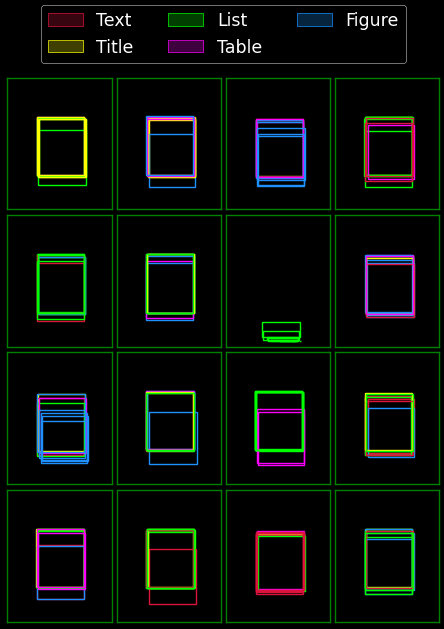

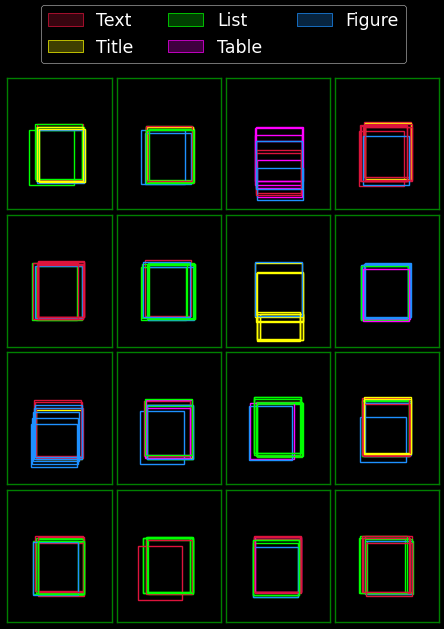

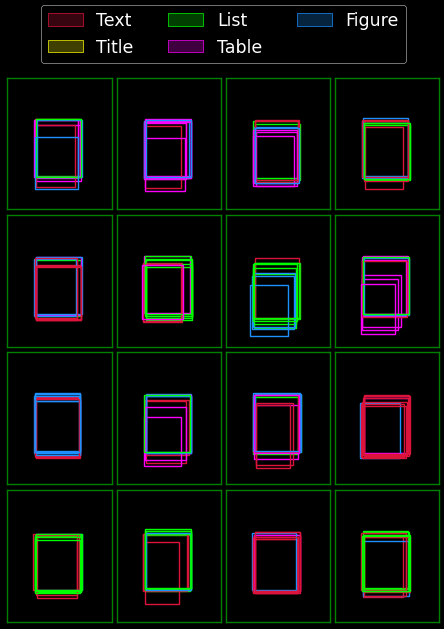

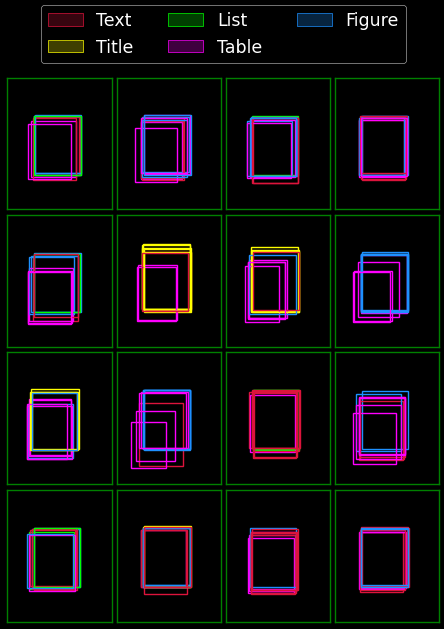

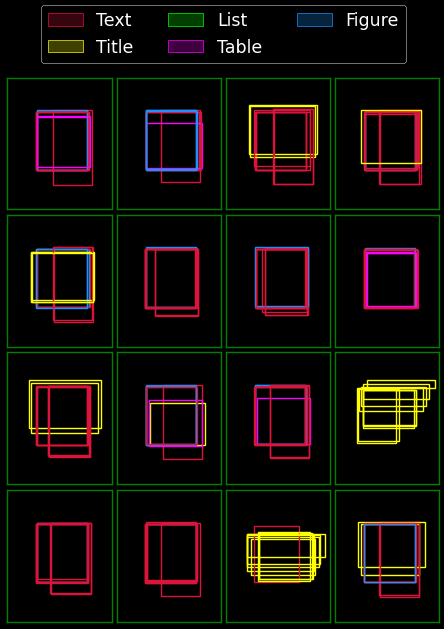

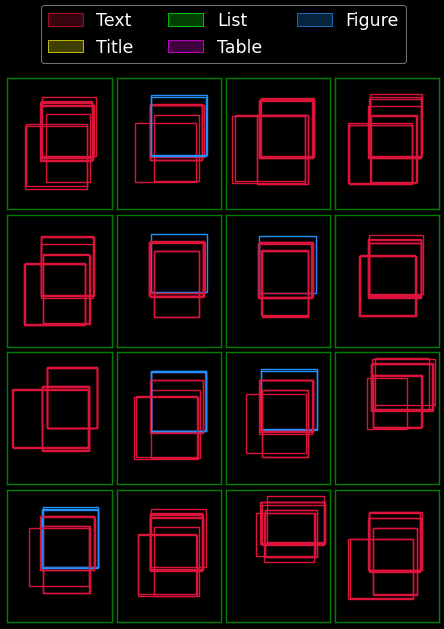

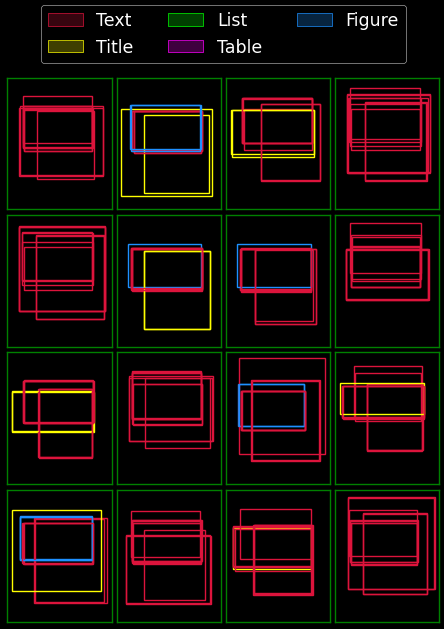

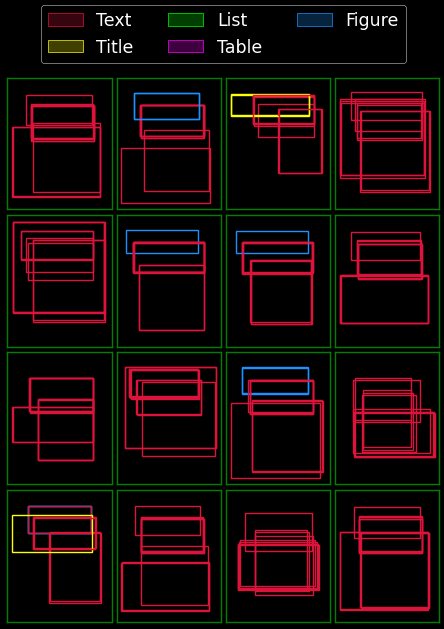

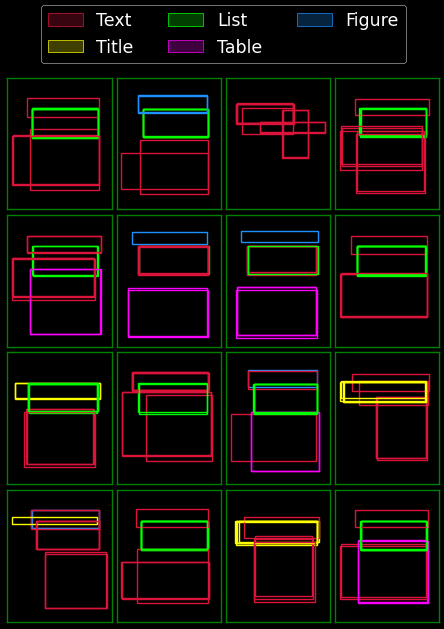

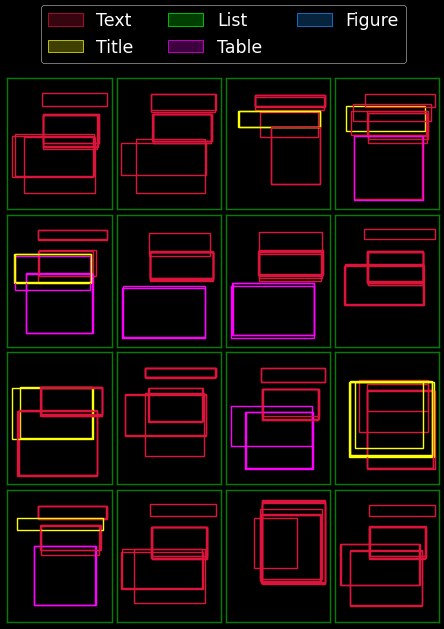

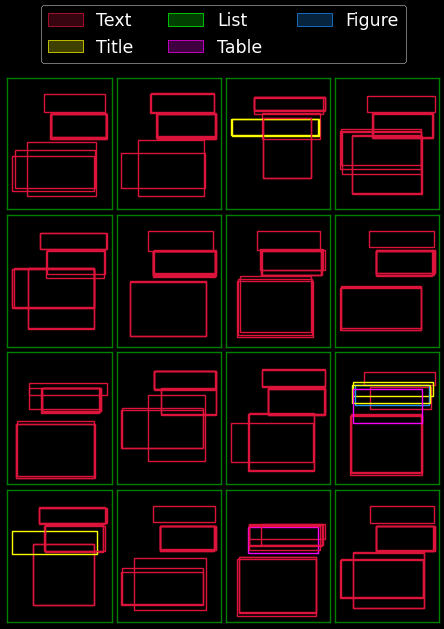

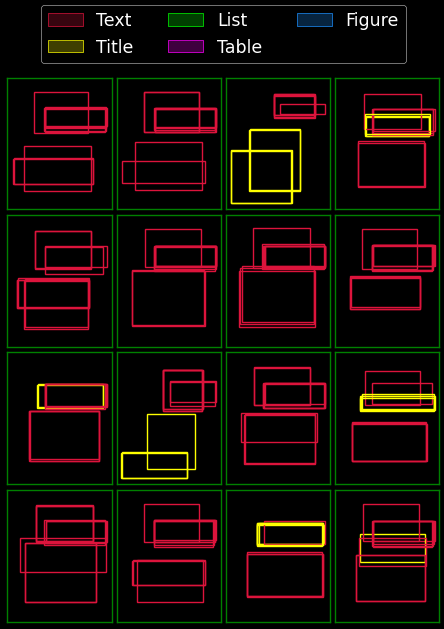

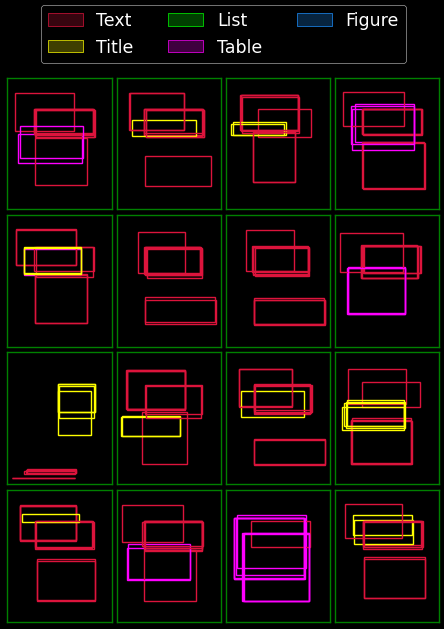

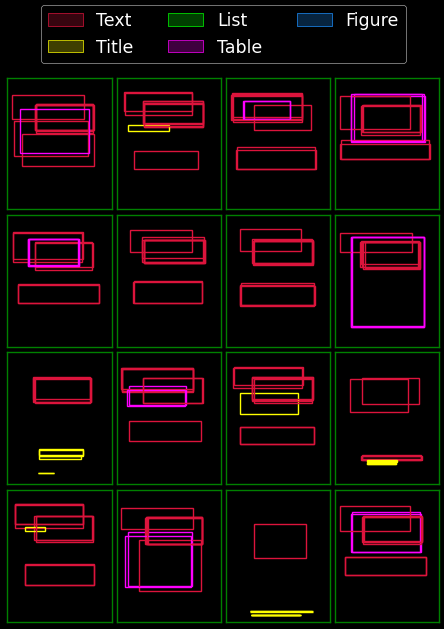

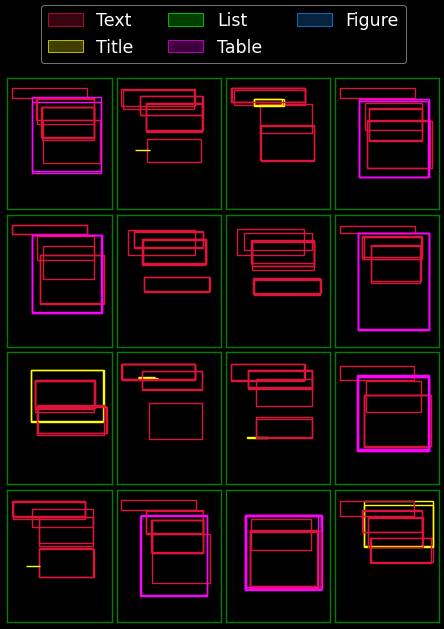

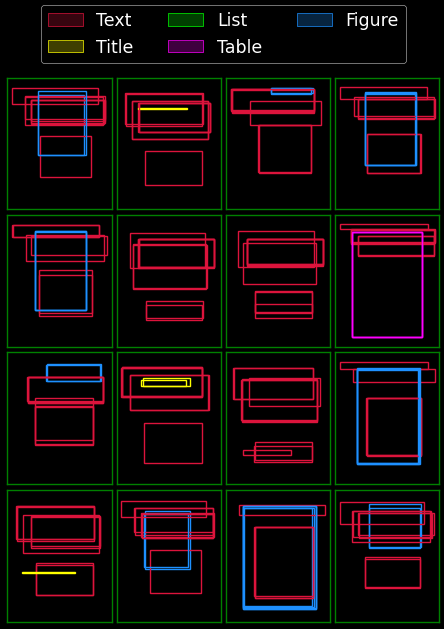

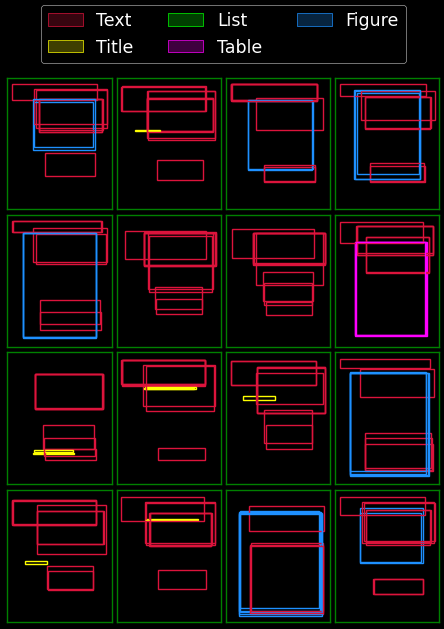

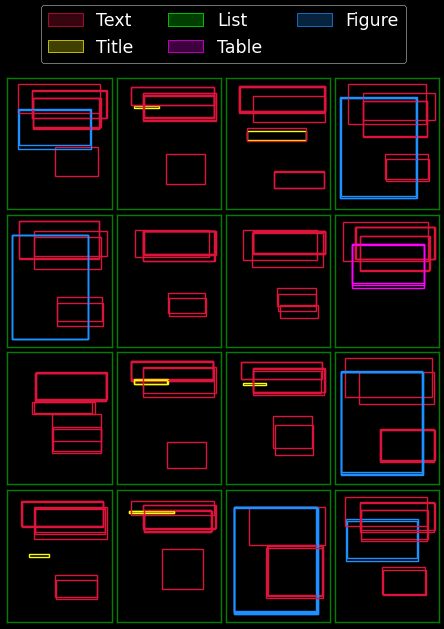

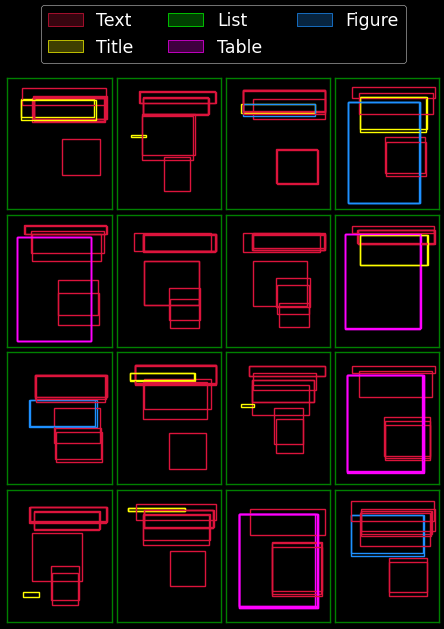

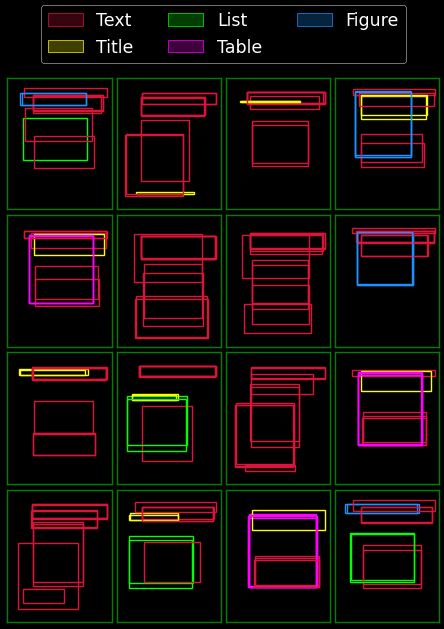

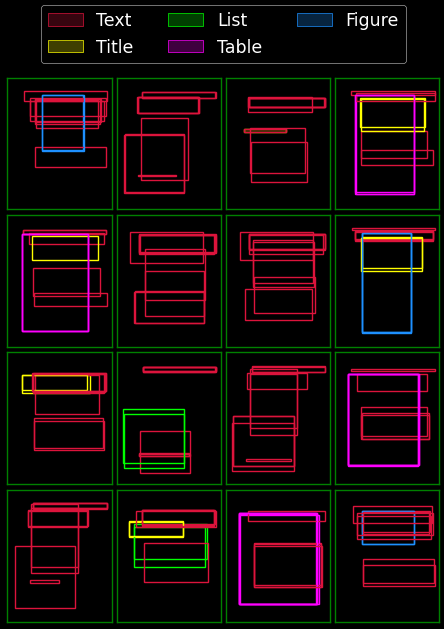

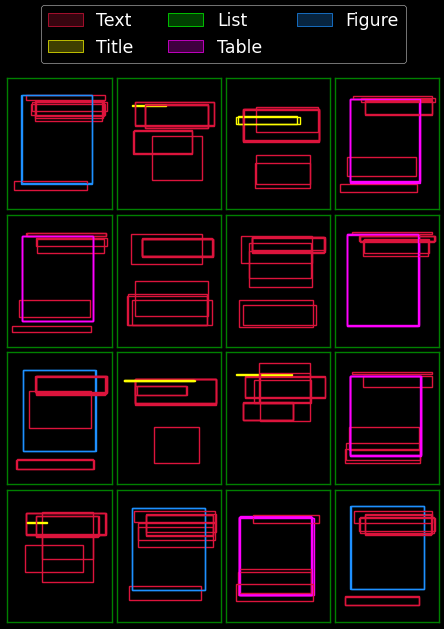

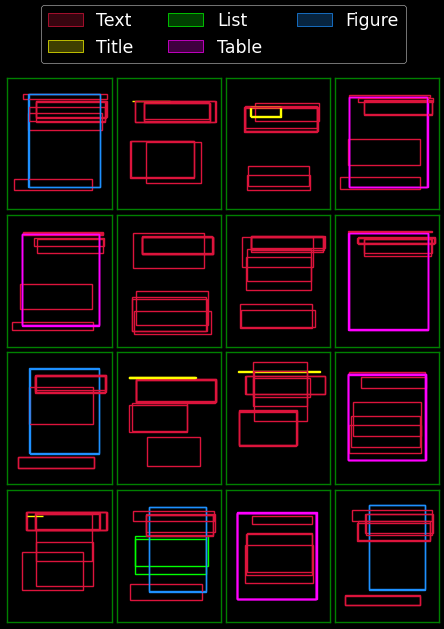

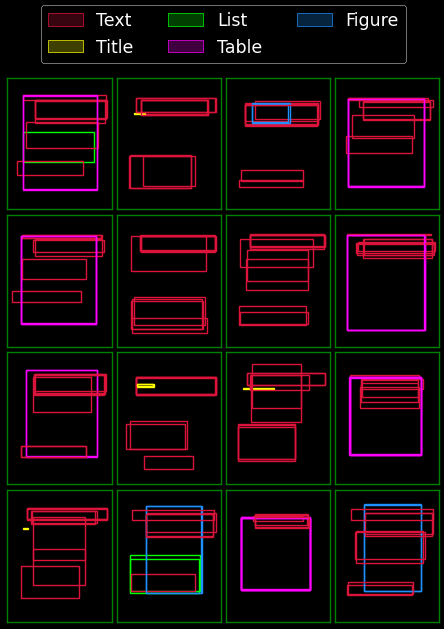

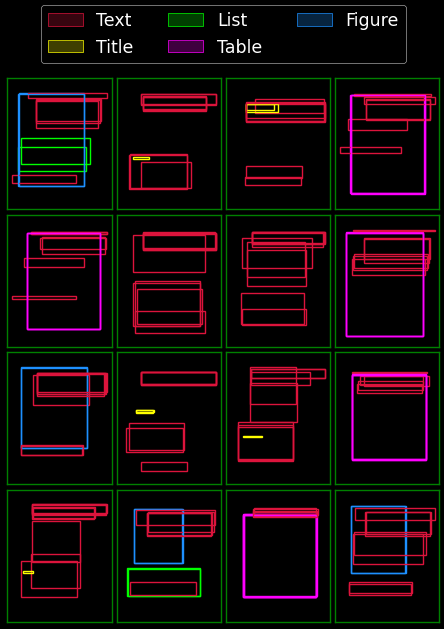

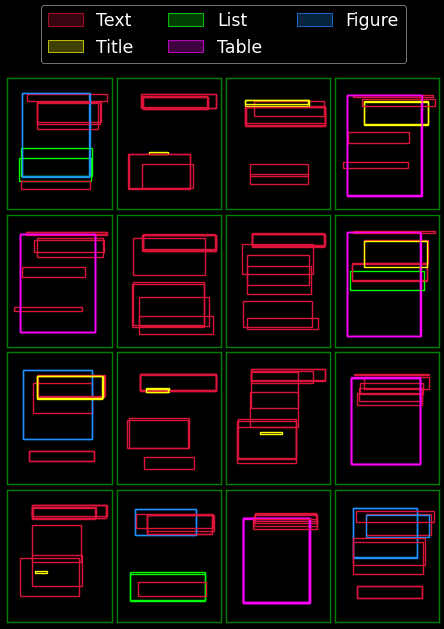

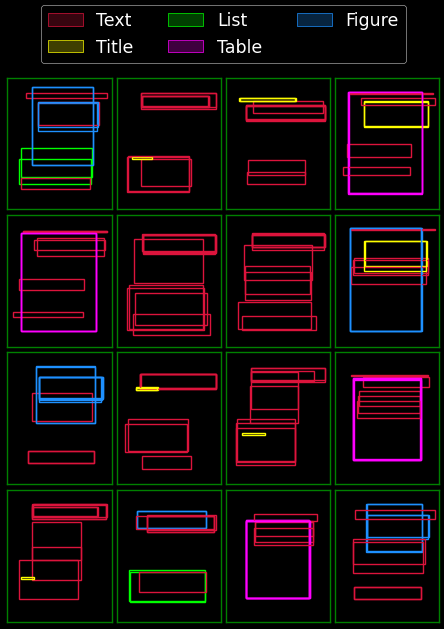

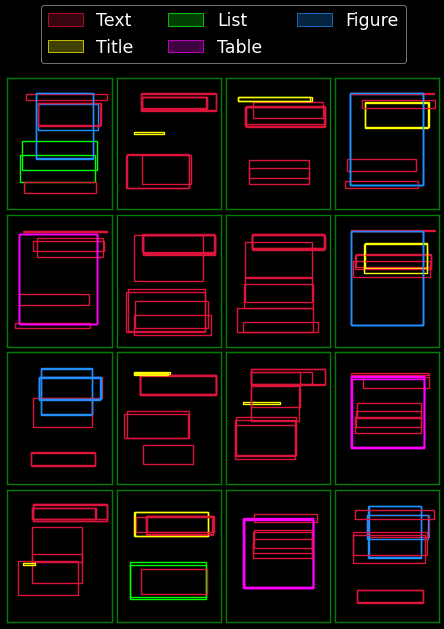

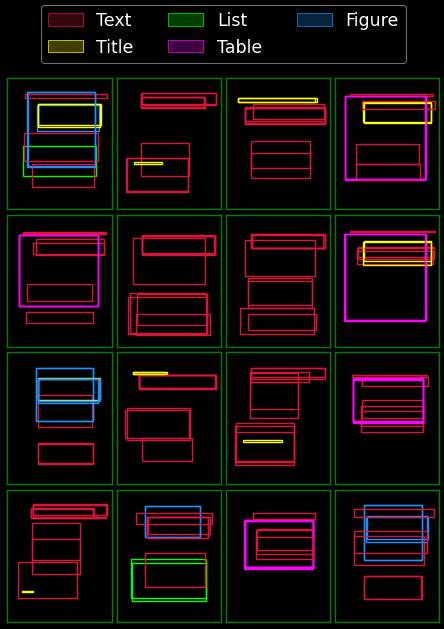

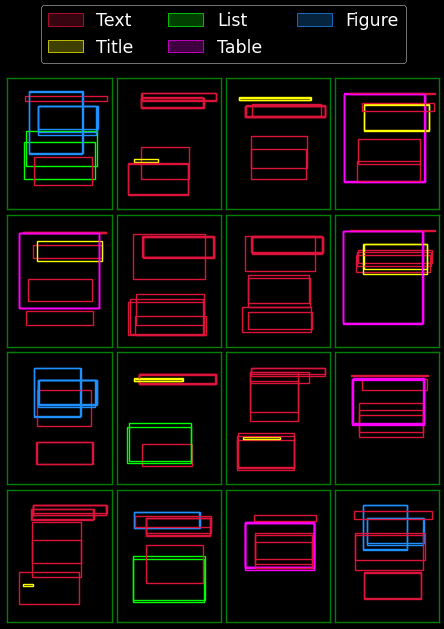

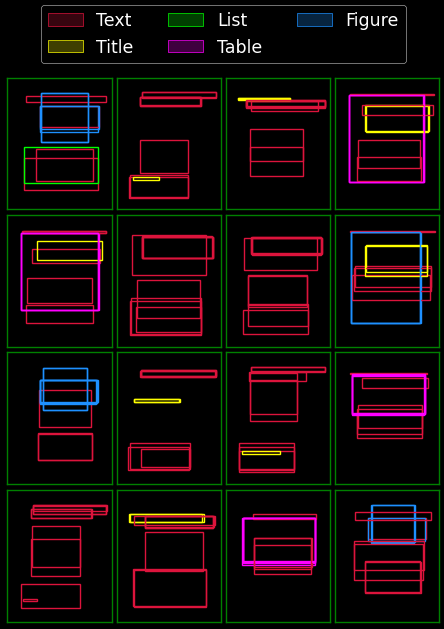

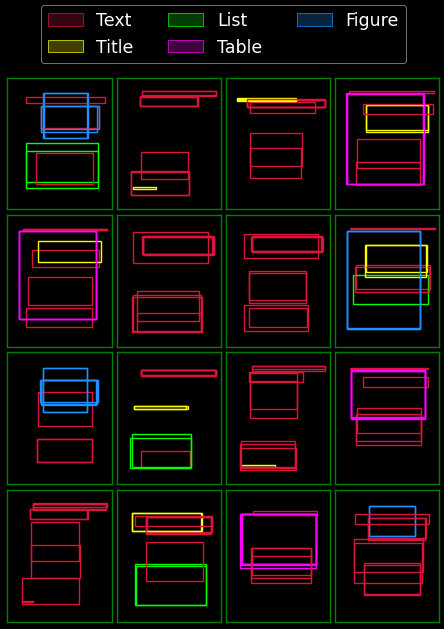

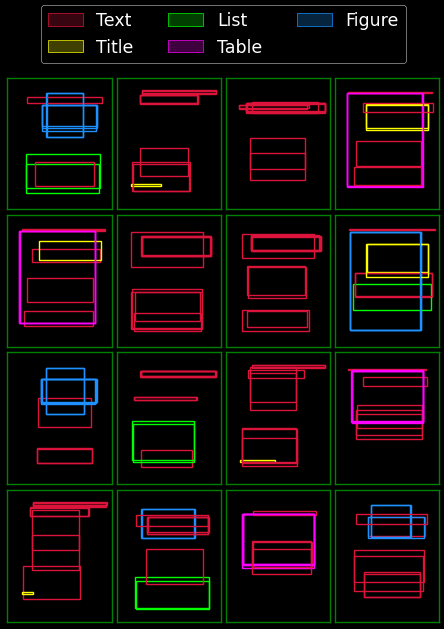

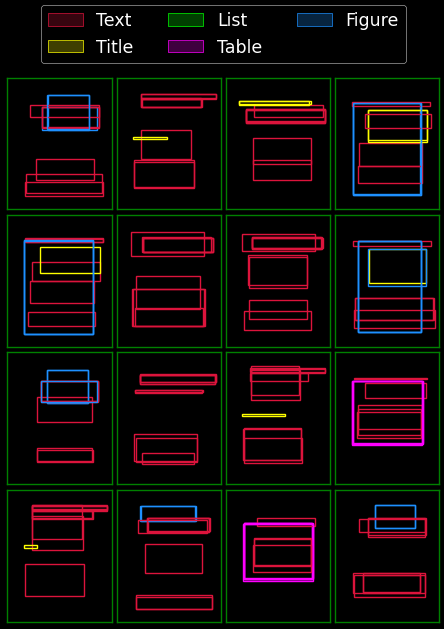

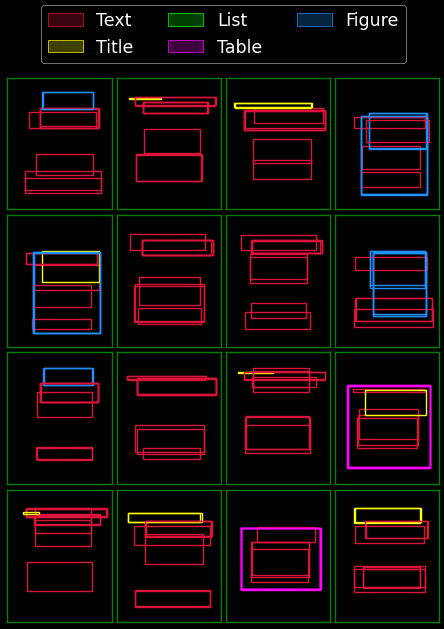

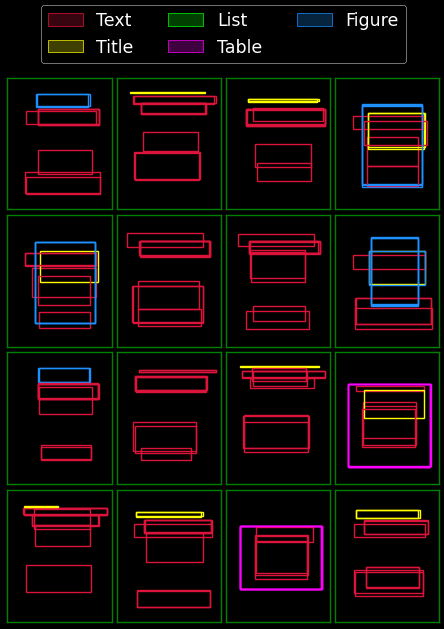

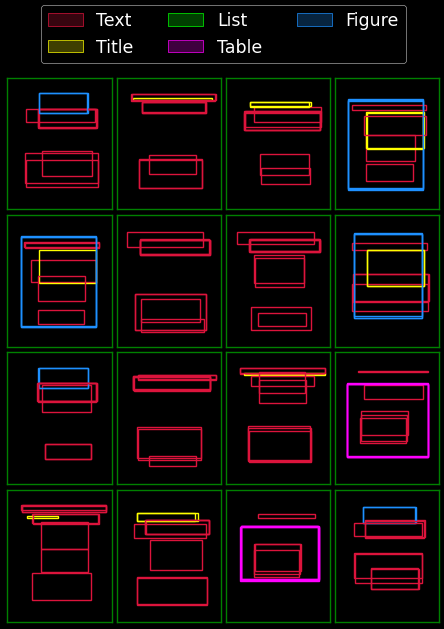

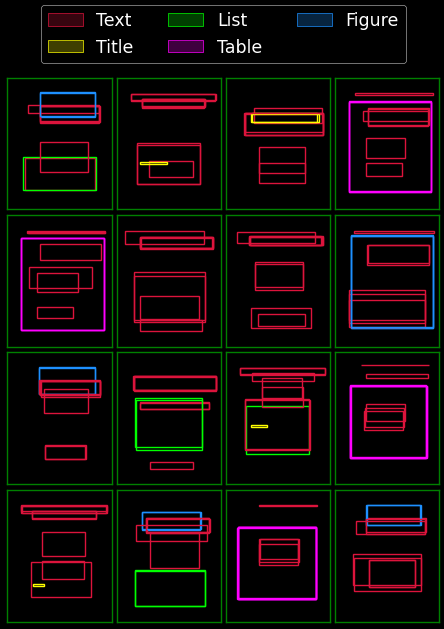

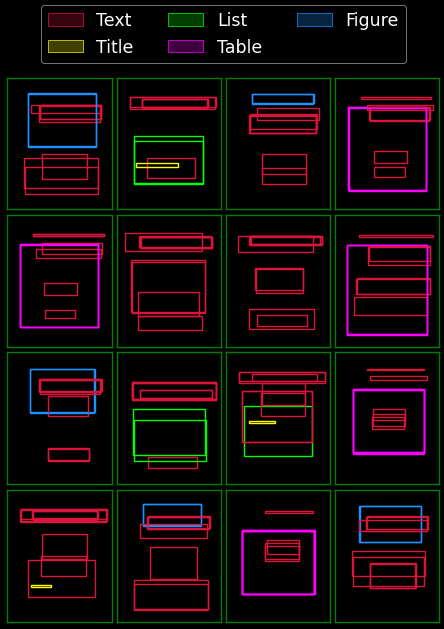

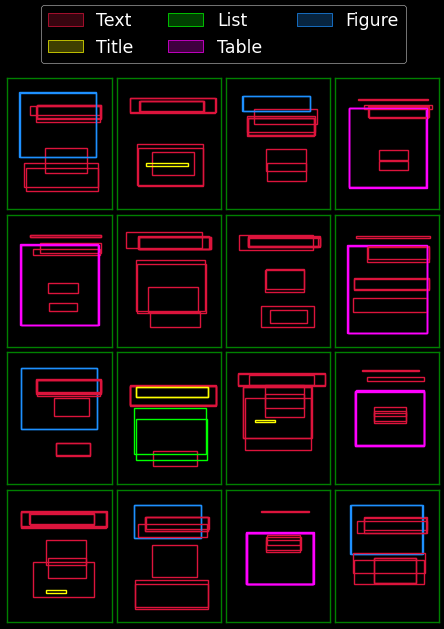

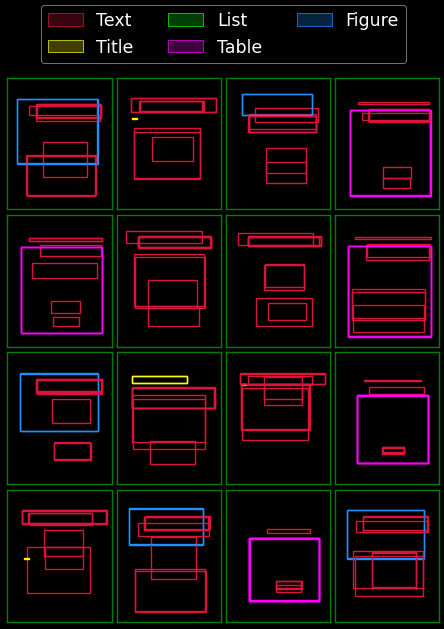

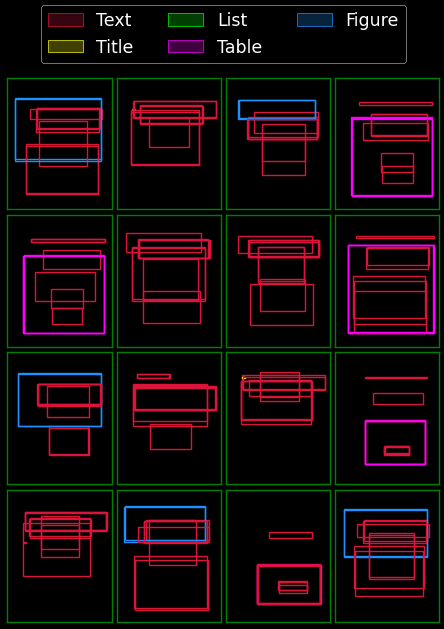

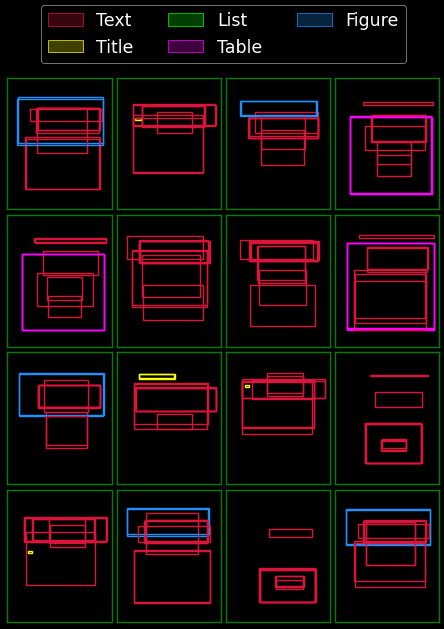

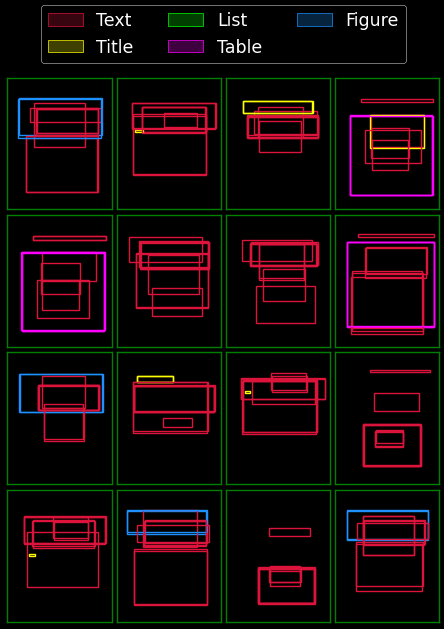

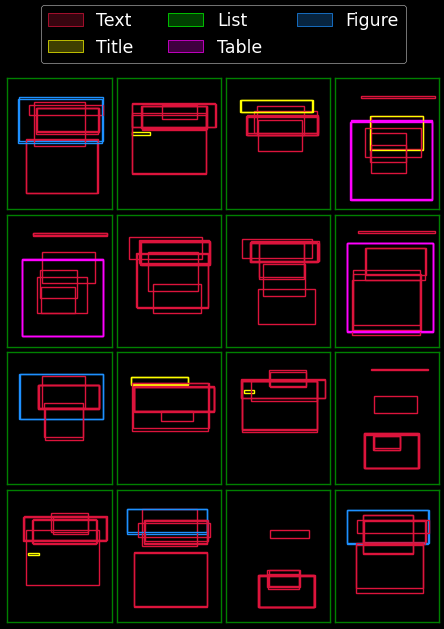

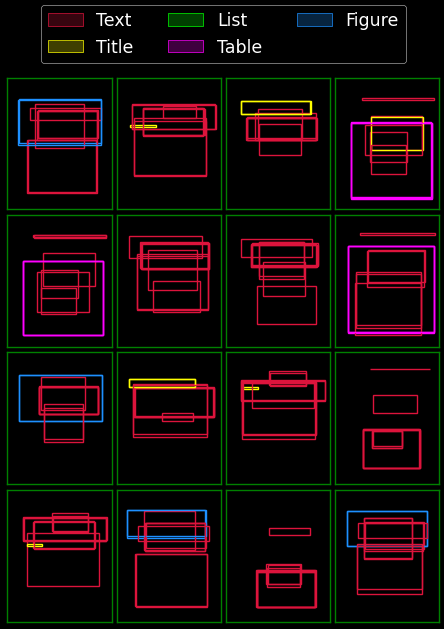

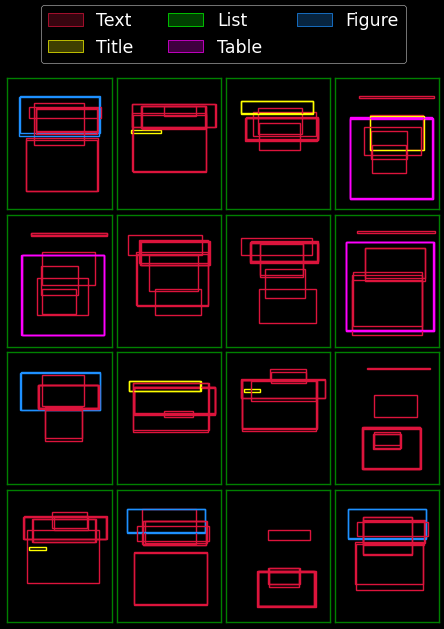

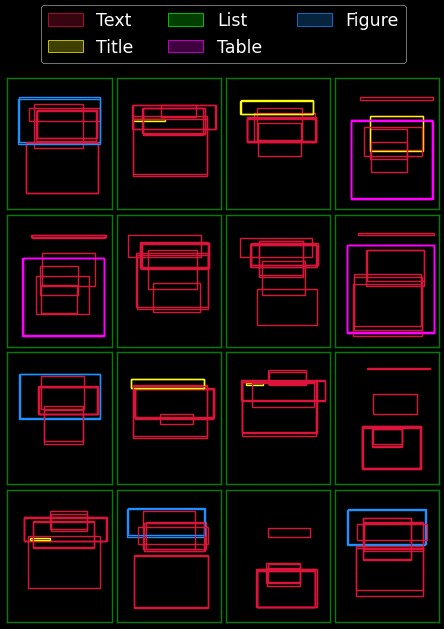

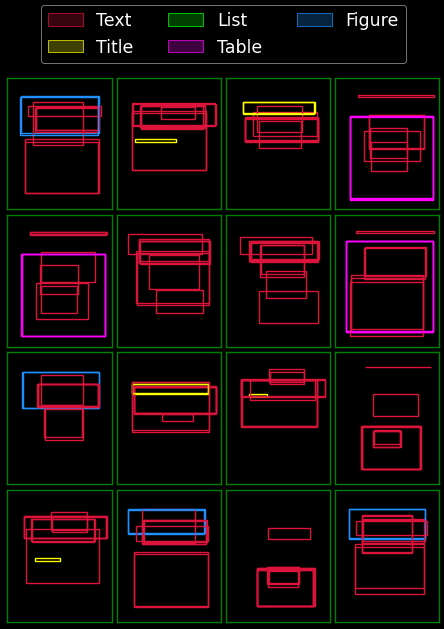

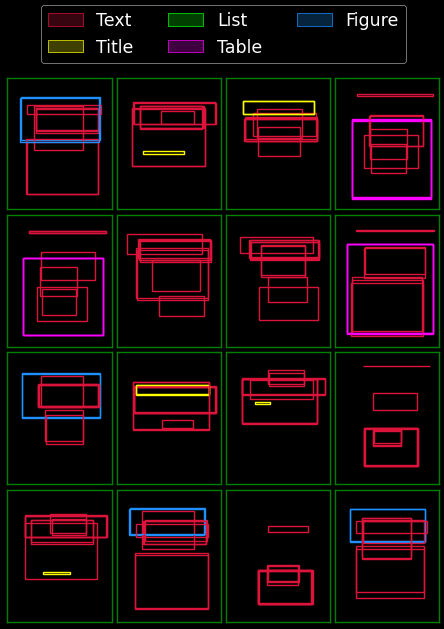

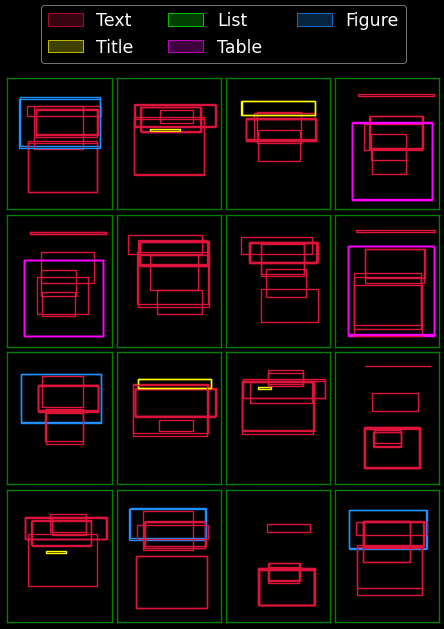

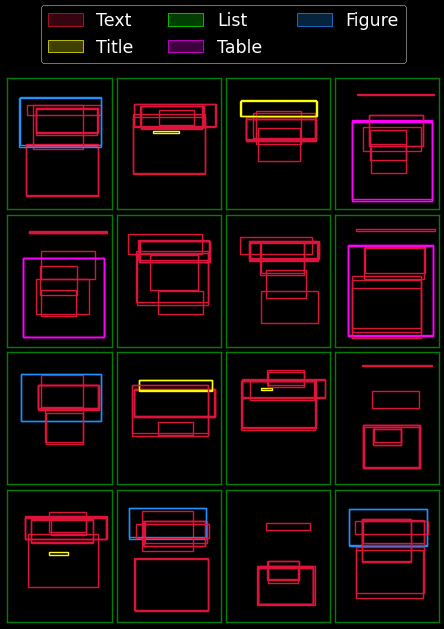

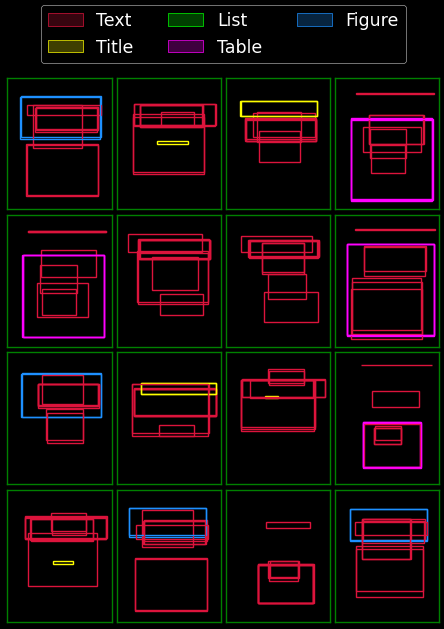

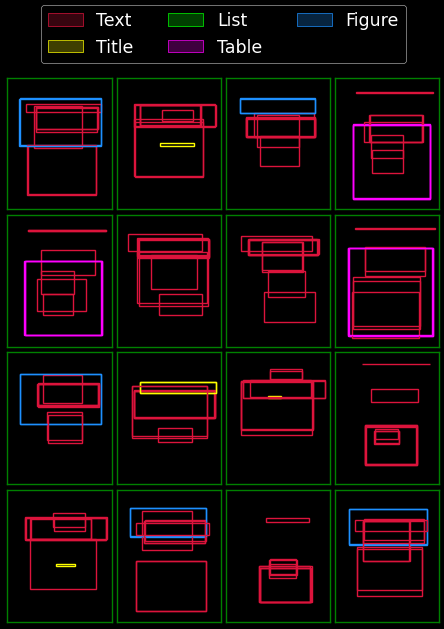

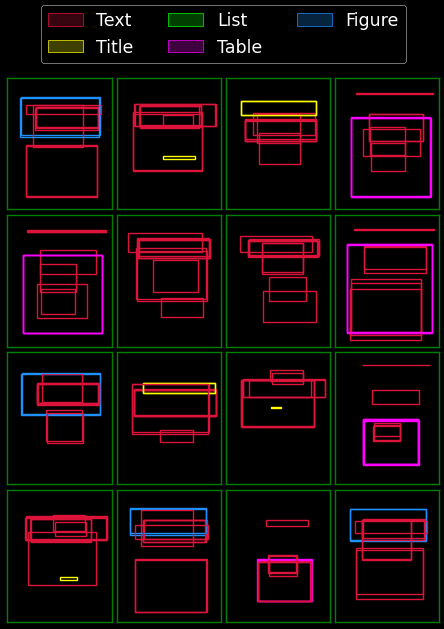

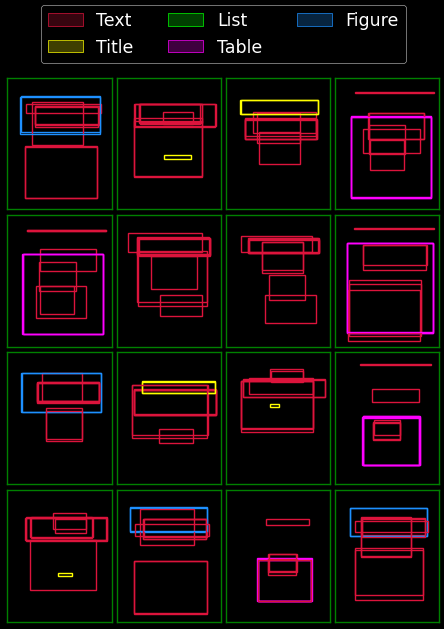

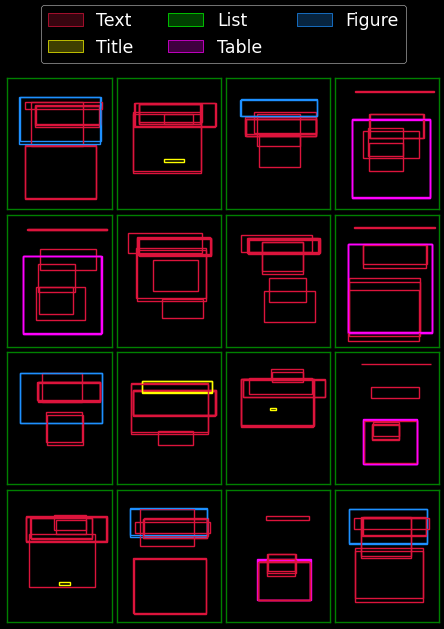

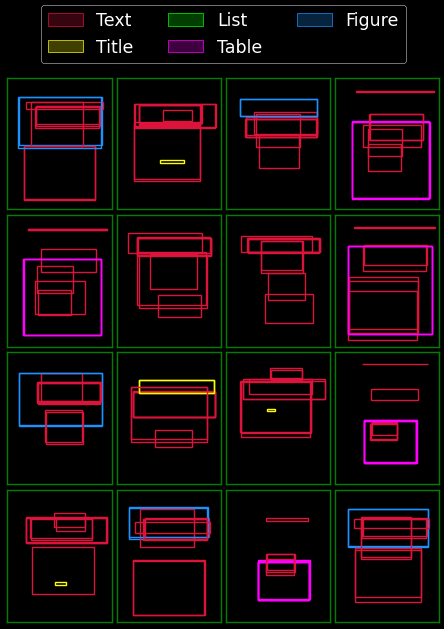

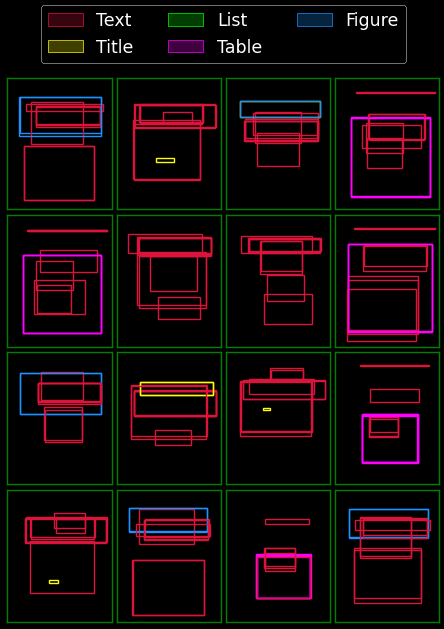

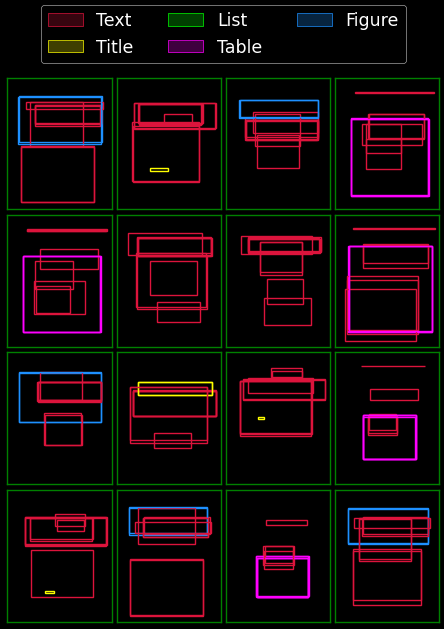

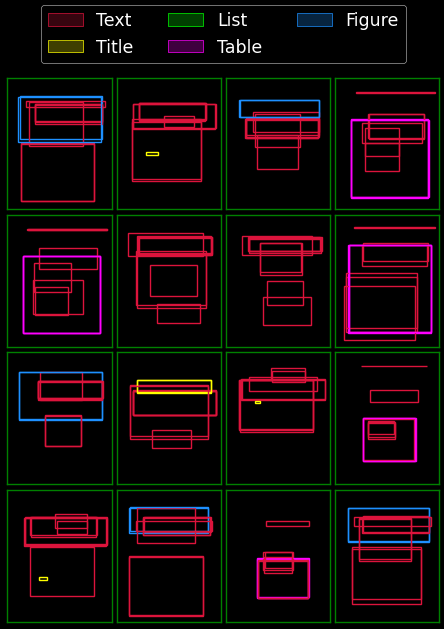

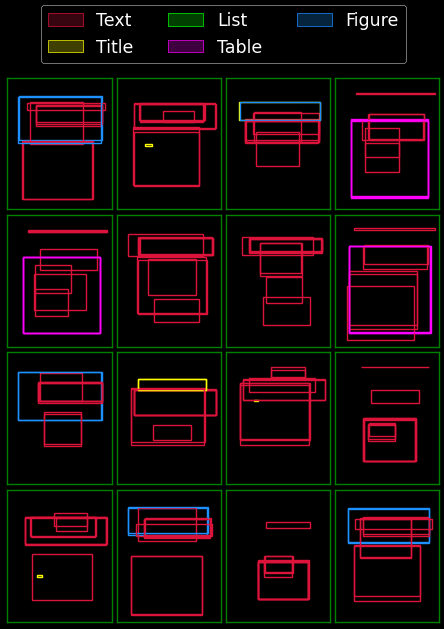

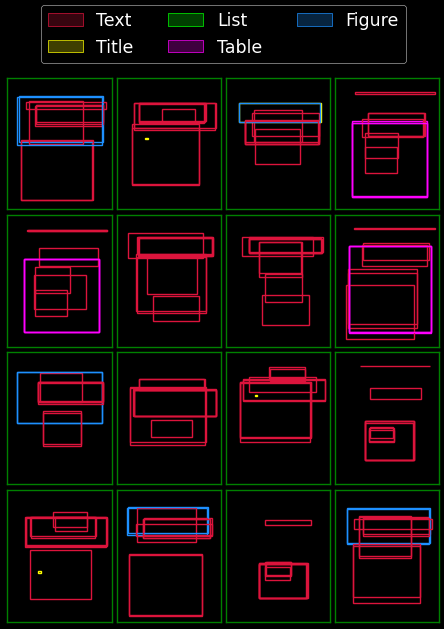

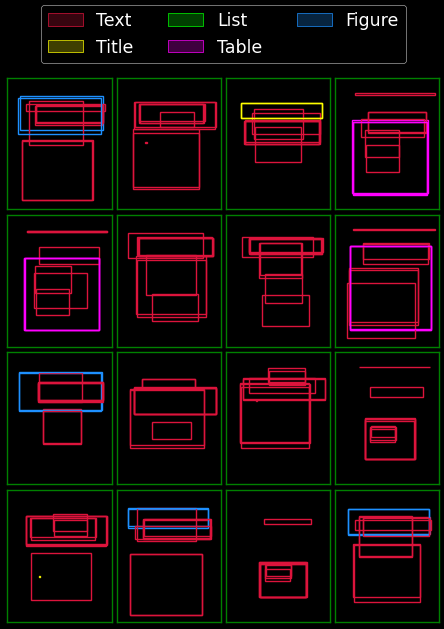

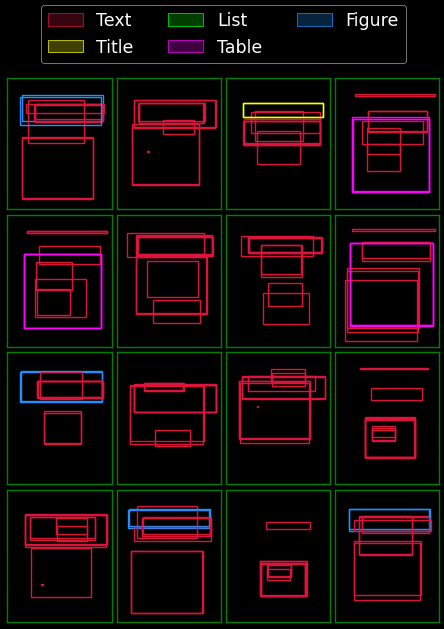

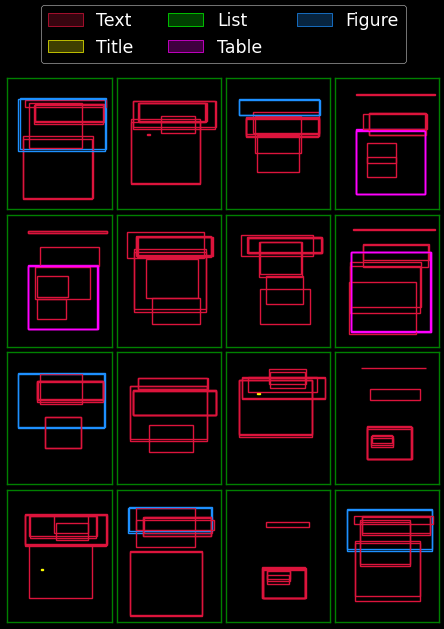

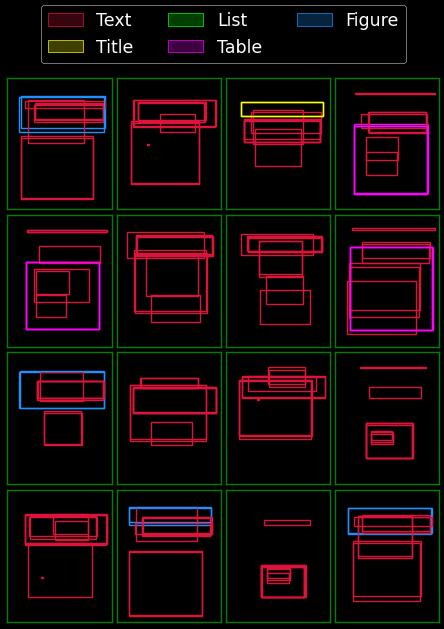

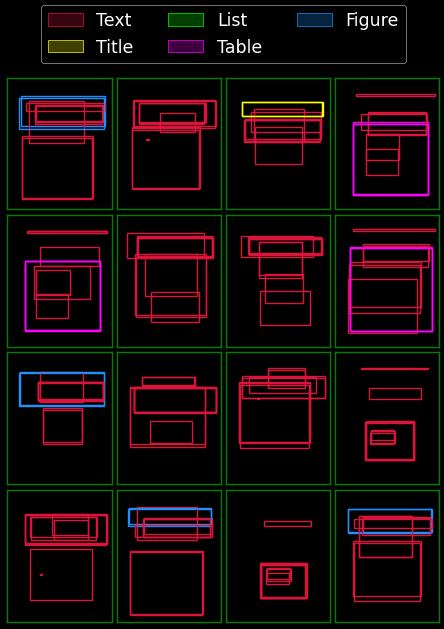

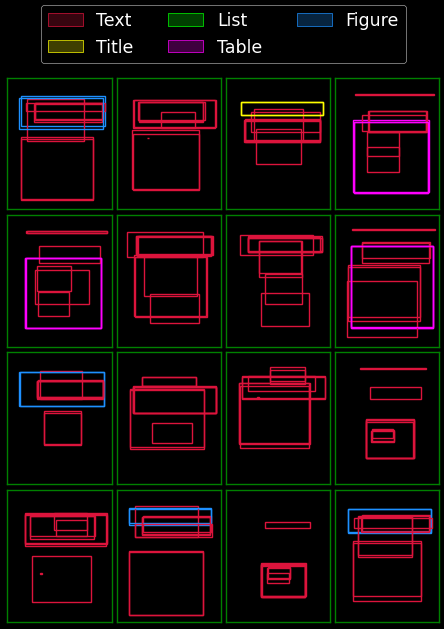

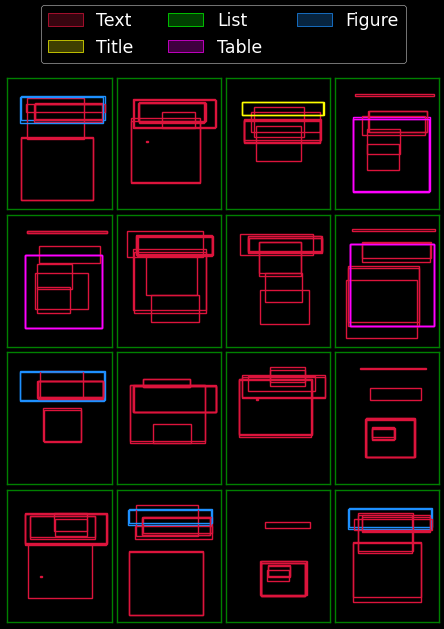

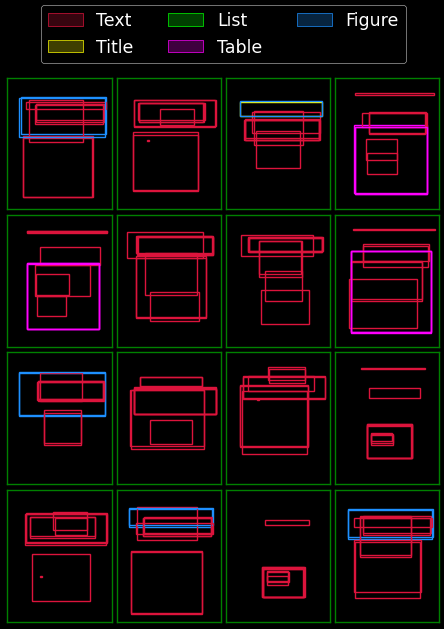

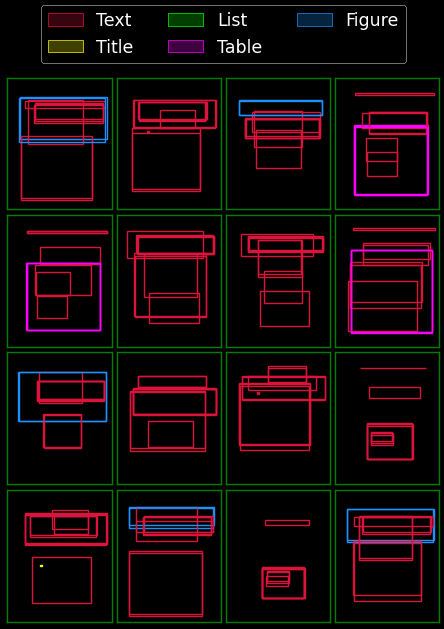

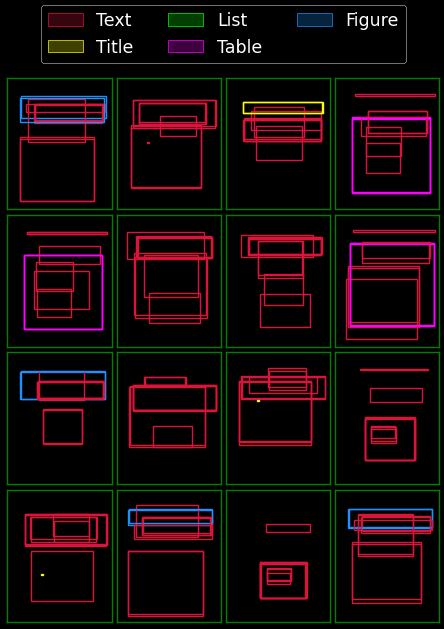

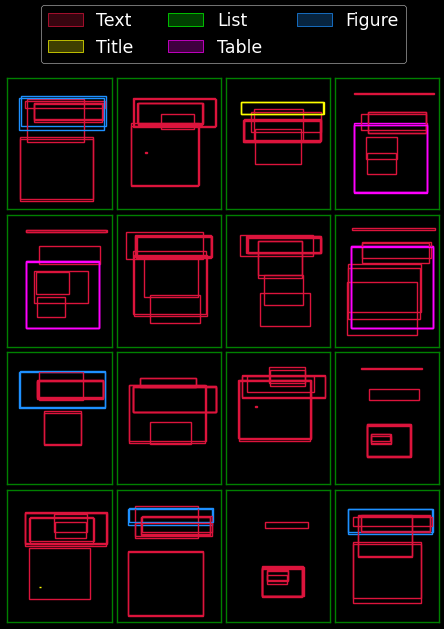

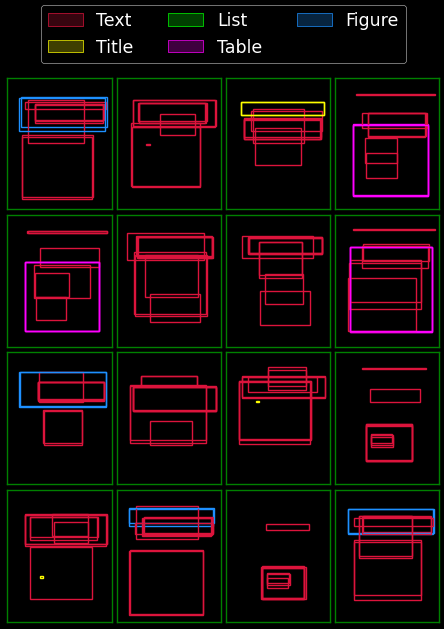

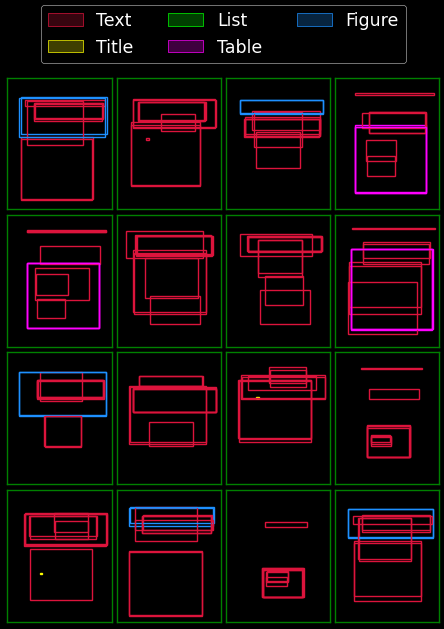

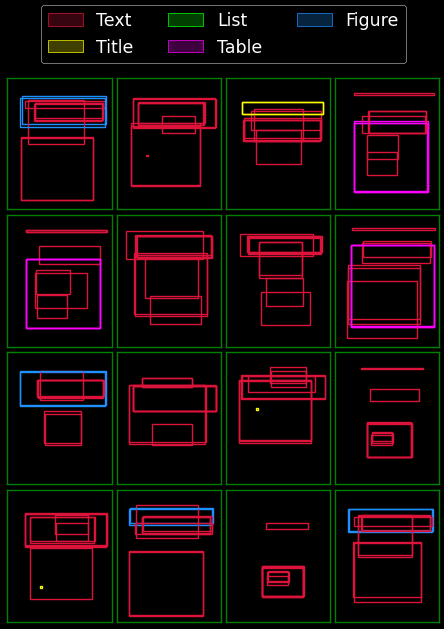

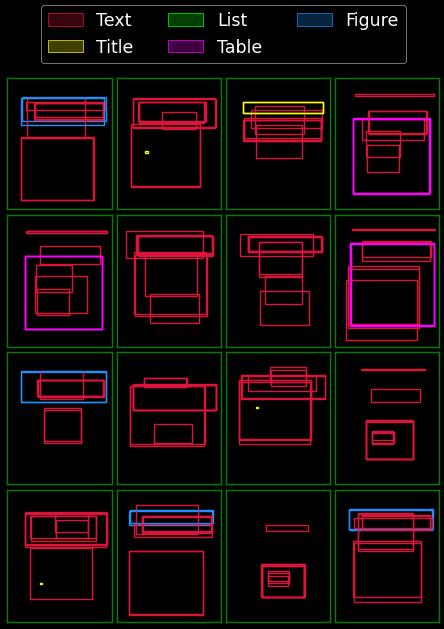

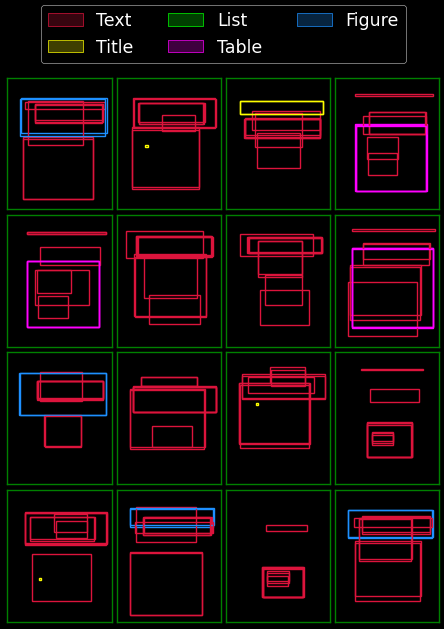

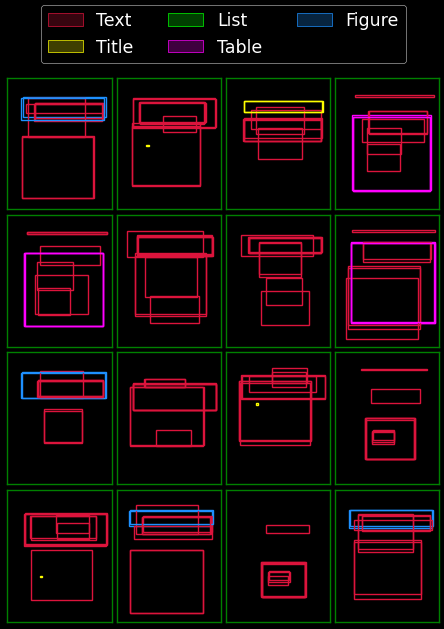

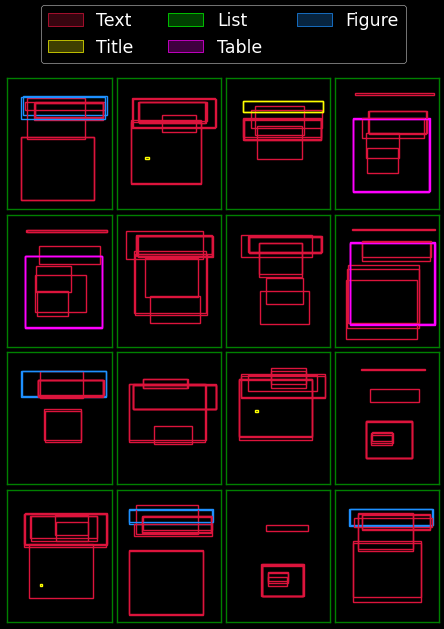

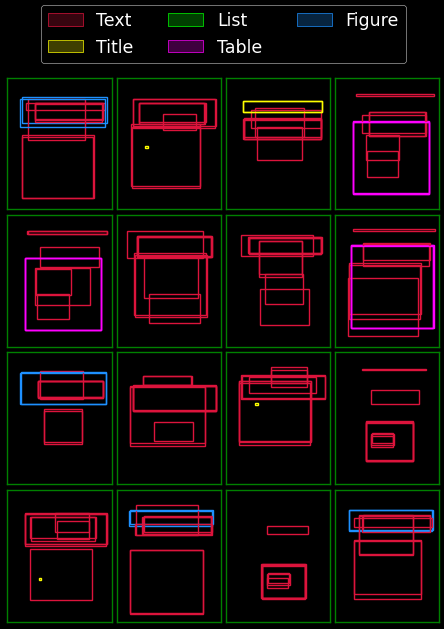

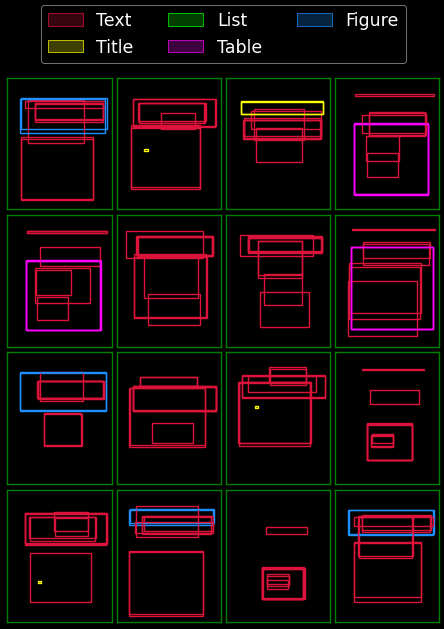

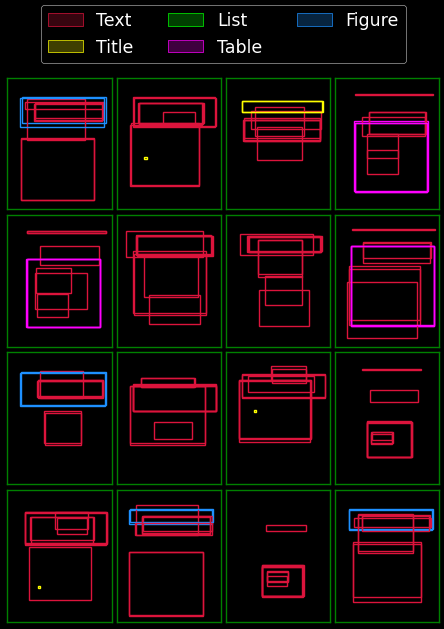

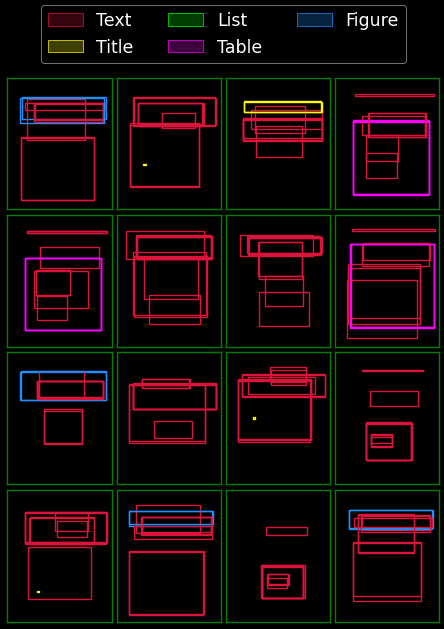

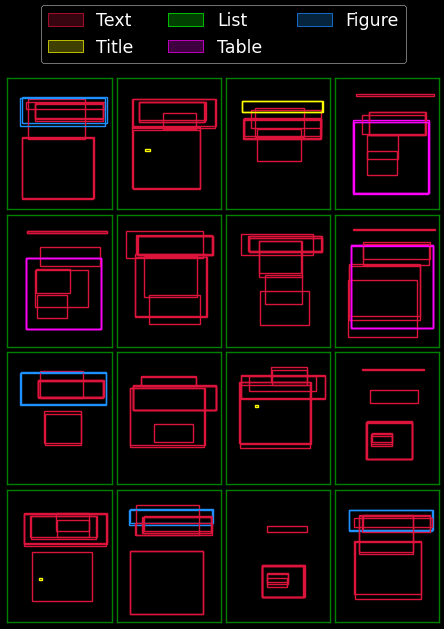

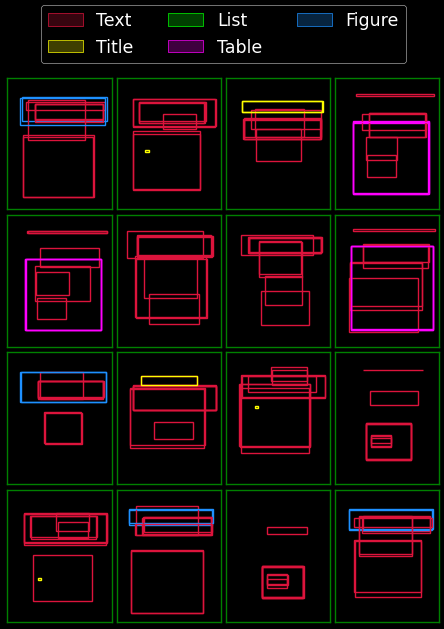

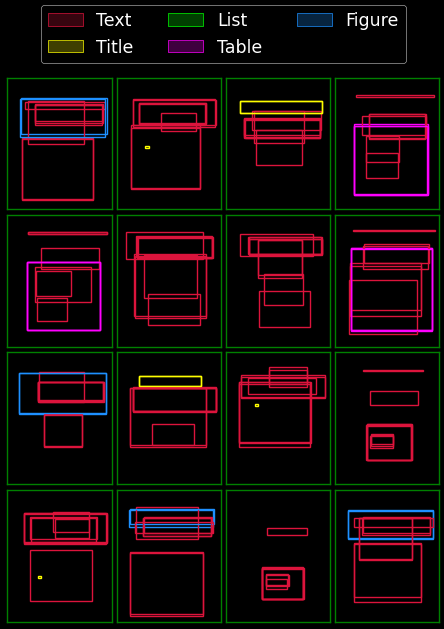

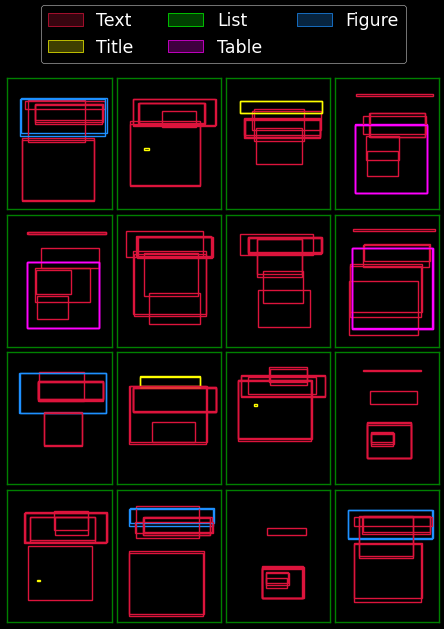

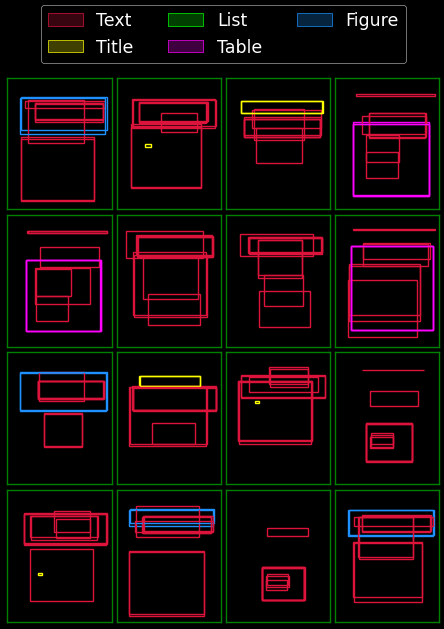

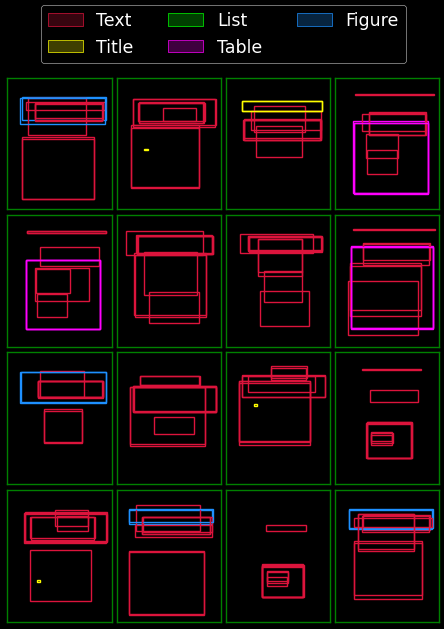

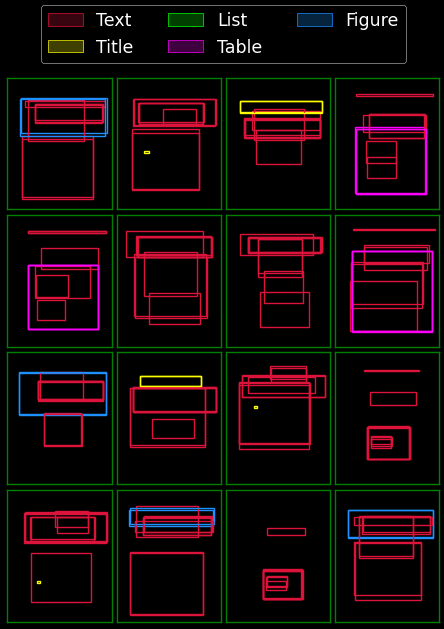

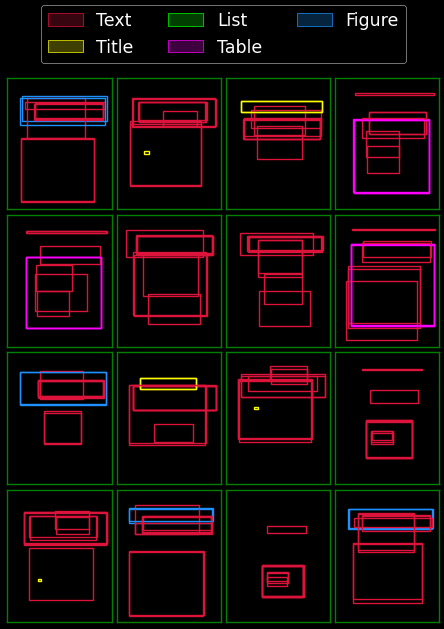

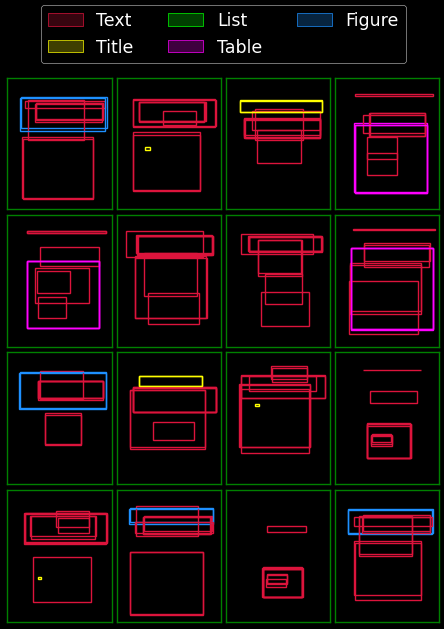

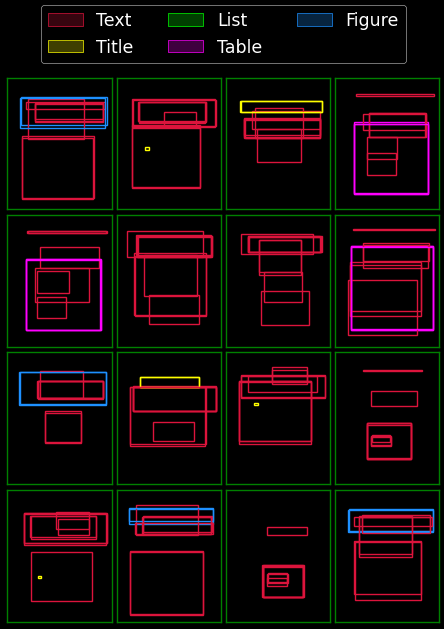

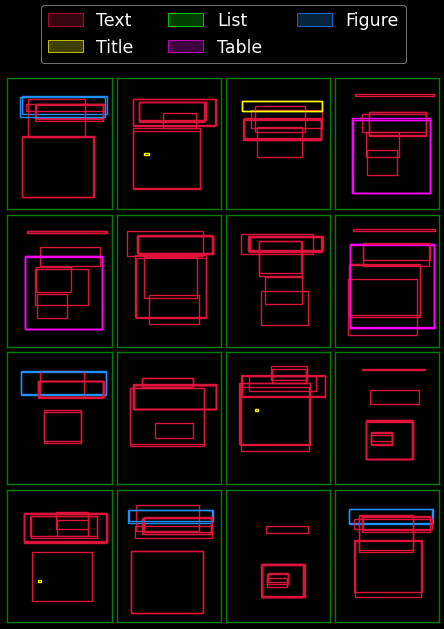

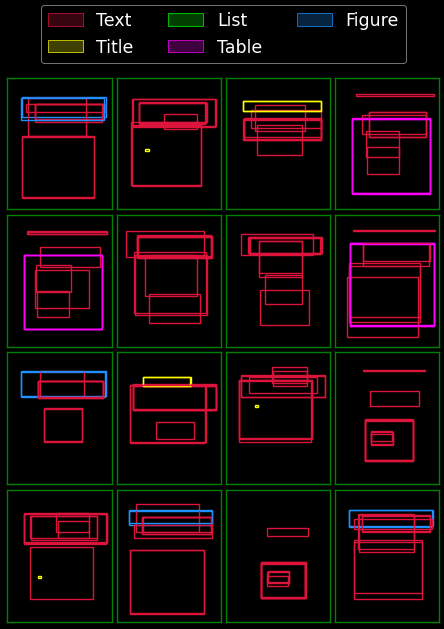

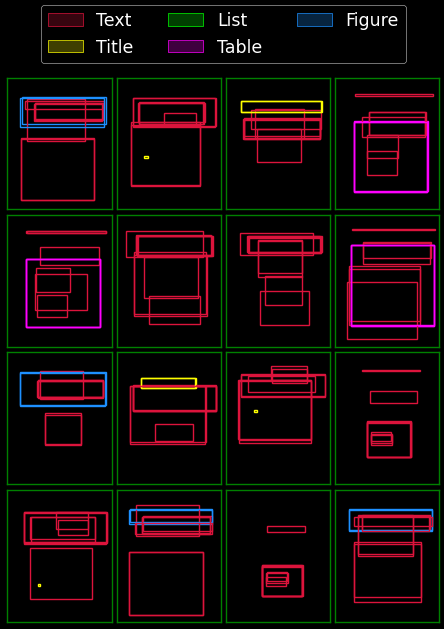

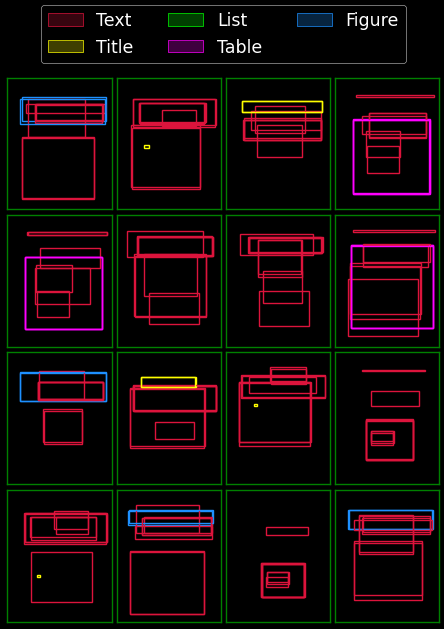

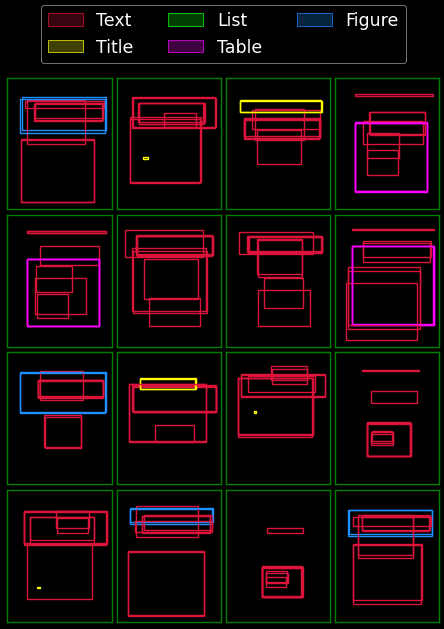

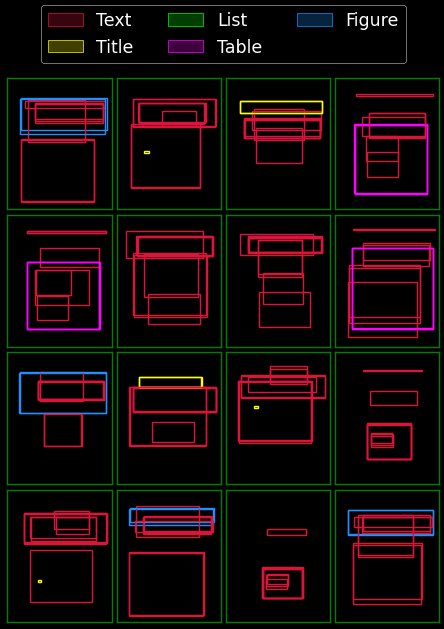

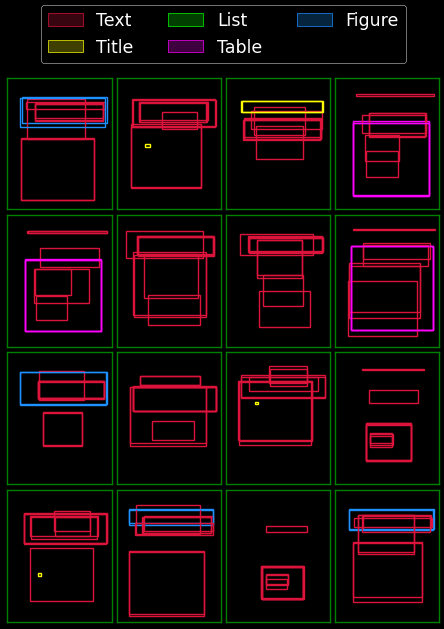

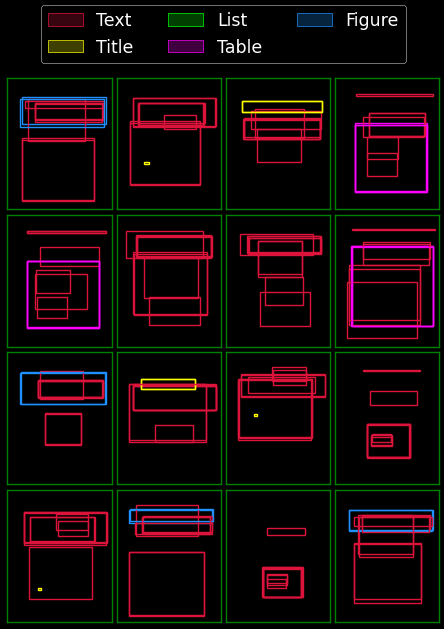

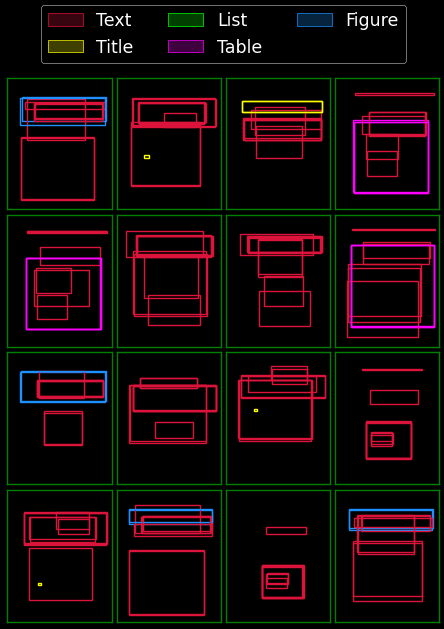

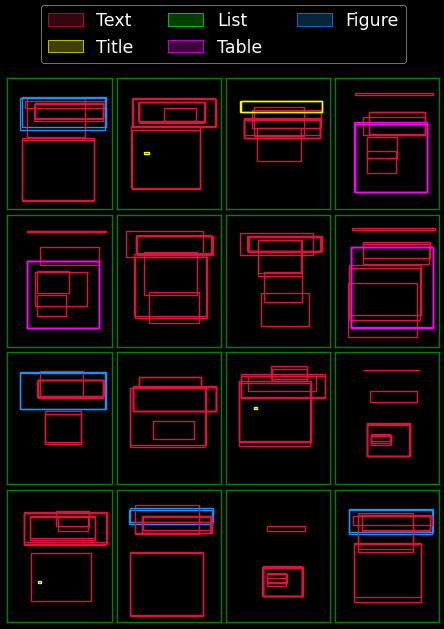

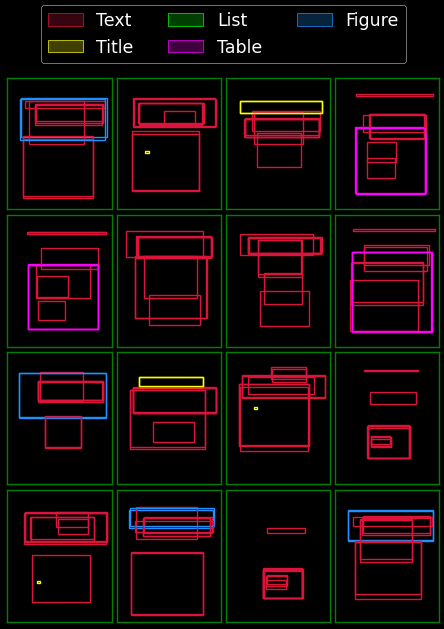

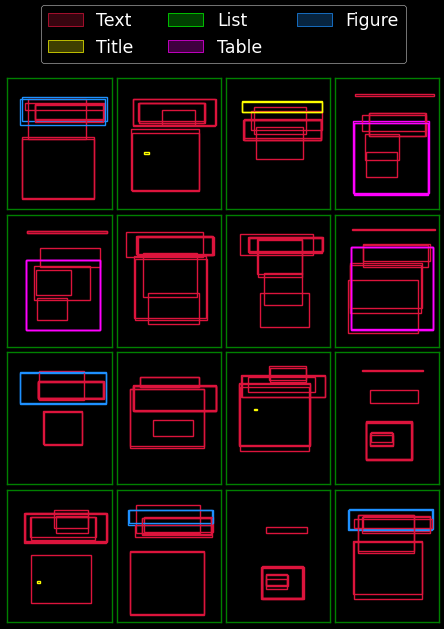

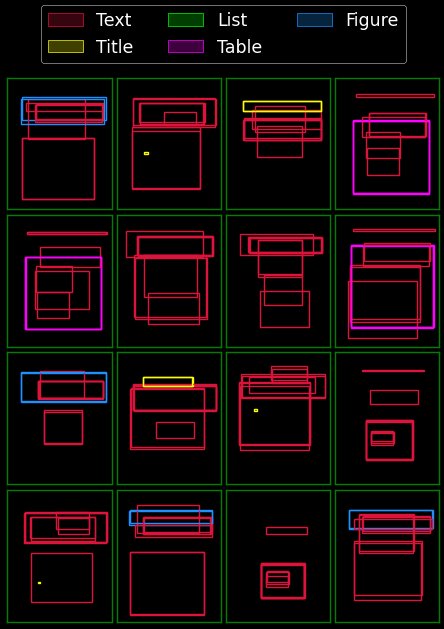

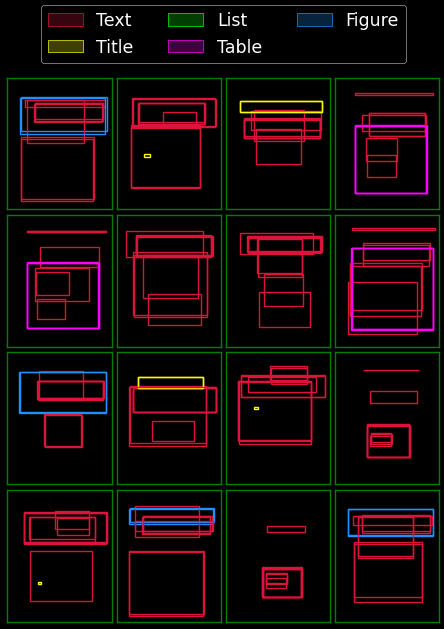

In [4]:
import os
import time
import math
from glob import glob
import tensorflow as tf
import numpy as np
import random
#from utils import *
#from modules import *
import matplotlib.pyplot as plt
from tensorflow.keras import initializers


import matplotlib.pyplot as plt

def plot_losses(d_losses, g_losses):
    # Calculate the number of epochs based on the length of discriminator losses
    epochs = len(d_losses)
    
    # Plot the discriminator losses over the epochs
    plt.plot(range(epochs), d_losses, label='Discriminator Loss')
    
    # Plot the generator losses over the epochs
    plt.plot(range(epochs), g_losses, label='Generator Loss')
    
    # Set the x-axis label as 'Epoch'
    plt.xlabel('Epoch')
    
    # Set the y-axis label as 'Loss'
    plt.ylabel('Loss')
    
    # Set the title of the plot as 'GAN Losses over Time'
    plt.title('GAN Losses over Time')
    
    # Add a legend to the plot
    plt.legend()
    
    # Display the plot
    plt.show()

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

class LayoutGAN(object):
    def __init__(self, geometric_dim=2, n_class=1, batch_size=64, n_component=128, layout_dim=(28, 28), d_lr=1e-5, g_lr=1e-5, update_ratio=2, clip_value=0.1, dataset_name='default', dataset_path='./data/pre_data_cls.npy', checkpoint_dir=None, sample_dir=None):
        self.batch_size = batch_size
        self.n_component = n_component
        self.n_class = n_class
        self.geometric_dim = geometric_dim
        self.layout_dim = layout_dim
        self.dataset_name = dataset_name
        self.checkpoint_dir = checkpoint_dir       

        # Load dataset from the specified path
        self.data = np.load(dataset_path)
        self.data = self.data[:70000]
        self.build_model(d_lr, g_lr)
        self.sample_dir = sample_dir
        self.update_ratio = update_ratio
        self.clip_value = clip_value
        self.epochs = 50

    def build_model(self, d_lr, g_lr):

        # Build the generator model
        self.G = self.build_generator()

        # Build the discriminator model
        self.D = self.build_discriminator()epoch_step = len(self.data) // self.batch_size

        # Create a learning rate schedule for the optimizers
        dlr = tf.keras.optimizers.schedules.ExponentialDecay(
            d_lr, decay_steps=20*epoch_step, decay_rate=0.1, staircase=True)

        # Initialize the optimizers for the generator and discriminator
        self.d_opt = tf.keras.optimizers.Adam(dlr)
        self.g_opt = tf.keras.optimizers.Adam(dlr)

    def step(self, real_data, noise, training=True, step=0):
      # Perform a single training step for the generator and discriminator.
        with tf.GradientTape() as disc_tape:
            # Calculate the discriminator loss
            disc_loss = self.discriminator_loss(real_data, noise)
            if(training):
                gradients_of_discriminator = disc_tape.gradient(
                    disc_loss, self.D.trainable_variables)
                self.d_opt.apply_gradients(
                    zip(gradients_of_discriminator, self.D.trainable_variables))
        for i in range(self.update_ratio):
            with tf.GradientTape() as gen_tape:
                # Calculate the generator loss
                gen_loss = self.generator_loss(noise)
                if(training):
                    gradients_of_generator = gen_tape.gradient(
                        gen_loss, self.G.trainable_variables)
                    self.g_opt.apply_gradients(
                        zip(gradients_of_generator, self.G.trainable_variables))

    def train(self):
      # Train the LayoutGAN model.
        epoch_step = len(self.data) // self.batch_size

      # Generate a sample of input data for visualization during training
        sample = self.data[0:self.batch_size]
        sample_inputs = np.array(sample).astype(np.float32)
        sample_z_bbox = np.random.normal(0.5, 0.15, (self.batch_size, 9, 4))
        sample_z_cls = np.identity(
            5)[np.random.randint(5, size=(self.batch_size, 9))]
        sample_z = np.concatenate([sample_z_bbox, sample_z_cls], axis=-1)

        counter = 1
        start_time = time.time()
        d_losses = []
        g_losses = []
      # Training loop
        for epoch in range(self.epochs):
          # Shuffle the training data for each epoch
            np.random.shuffle(self.data)
            batch_idxs = len(self.data) // self.batch_size

            for idx in range(0, batch_idxs):
              # Retrieve a batch of real images from the training data
                batch = self.data[idx*self.batch_size:(idx+1)*self.batch_size]
                batch_images = np.array(batch).astype(np.float32)

              # Generate noise inputs for the generator
                batch_z_bbox = np.random.normal(
                    0.5, 0.15, (self.batch_size, 9, 4))
                batch_z_cls = np.identity(
                    5)[np.random.randint(5, size=(self.batch_size, 9))]
                batch_z = np.concatenate([batch_z_bbox, batch_z_cls], axis=-1)

              # Perform a training step for the generator and discriminator
                g_loss, d_loss = self.step(batch_images, batch_z, step=idx)
                counter += 1
                if np.mod(counter, 50) == 0:
                  # Generate samples from the generator for visualization
                    current_decayed_lr = self.d_opt._decayed_lr(
                        tf.float32).numpy()
                    print("Epoch: [%2d] [%4d/%4d] time: %4.4f, lr:%.3E, d_loss: %.4f, g_loss: %.4f"
                          % (epoch, idx, batch_idxs, time.time()-start_time, current_decayed_lr, d_loss, g_loss))

                if np.mod(counter, 500) == 0:
                    G_samples = self.G(sample_z, training=False)
                  # Save generated samples as an image
                    path = '{}/train_{:02d}_{:04d}_{:2.4f}_{:2.4f}.jpg'.format(
                        self.sample_dir, epoch, idx, d_loss, g_loss)
                    change = convert_to_cxywh(np.array(G_samples))
                    plot_layouts(change, colors=colors,
                                 class_names=class_names, path=path)
                  # Perform a step for the generator and discriminator using the sample inputs
                    g_loss, d_loss = self.step(
                        sample_inputs, sample_z, training=False)
                    print("[Sample] d_loss: %.8f, g_loss: %.8f" %
                          (d_loss, g_loss))
                    d_losses.append(d_loss)
                    g_losses.append(g_loss)
    # for Plot and visualize the losses over time
        #plot_losses(d_losses, g_losses)

    def render(self):
          # Placeholder method, currently does nothing
        pass

    def build_discriminator(self):
          # Build and return the Discriminator model.
        return Discriminator(layout_dim=self.layout_dim, render=layout_bbox)

    def build_generator(self):
          # Build and return the Generator model.
        return Generator(n_filters=1024, output_dim=self.geometric_dim, n_component=self.n_component, n_class=self.n_class)

    def generator_loss(self, z):
          # Compute the generator loss.
        x = self.G(z, training=True)
        fake_score = self.D(x, training=True)
        g_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_score, labels=tf.ones_like(tf.sigmoid(fake_score))))
        return g_loss

    def discriminator_loss(self, x, z):
          # Compute the discriminator loss.
        x_fake = self.G(z, training=True)
        true_score = self.D(x, training=True)
        fake_score = self.D(x_fake, training=True)
        d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=true_score, labels=tf.ones_like(tf.sigmoid(true_score))))
        d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(
            logits=fake_score, labels=tf.zeros_like(tf.sigmoid(fake_score))))
        d_loss = d_loss_real + d_loss_fake
        return d_loss

if __name__ == '__main__':
    # Set hyperparameters and paths
    batch_size = 64
    n_component = 9
    n_class = 5
    geometric_dim = 4
    sample_dir = "C:/Users/jay rana/downloads/samples/box_results1"
    dataset_path = "C:/Users/jay rana/downloads/sorted_c1publay.npy"

    # Create an instance of LayoutGAN
    gan = LayoutGAN(
        batch_size=batch_size,
        n_component=n_component,
        n_class=n_class,
        layout_dim=(60, 40),
        geometric_dim=geometric_dim,
        sample_dir=sample_dir,
        dataset_path=dataset_path
    )

    # Train the LayoutGAN
    gan.train()


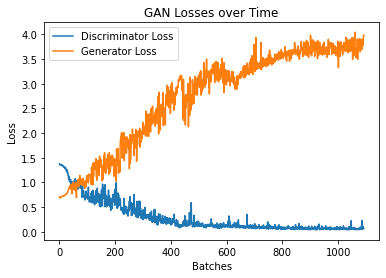

In [5]:
plot_losses(d_loss, g_loss)